# Projet 2 : Analyse des données de systèmes éducatifs

## 0. Importations des modules et des données

In [4]:
## IMPORTATIONS
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

idx  = pd.IndexSlice

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
#% matplotlib notebook
# graphes interactifs
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from IPython.display import Image
import scipy.stats as st
#import statsmodels.api as sm
#from sklearn.datasets import load_iris
#iris_df_ori = load_iris()

####     A ESSAYER      #######################################################
# GRAPHES INTERACTIFS


# POUR LES GRAPHIQUES
# % matplotlib inline 
# plt.rcParams['figure.figsize'] = [9.5, 6] # ajuster la taille

# POUR DESACTIVER LA TOOLBOX GRAPHES TOP GRANDS
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [5]:
## FONCTION SORTANT UN DATAFRAME D'INFOS (complémentaire du describe)

def desc_bis (df):
    nb_li = df.index.size
    nb_col = df.columns.size
    tot = nb_li*nb_col    
    infos = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'}) 
    infos = infos.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'null'}))
    return infos

In [6]:
def infos (df):
    nb_li = df.shape[0]
    nb_co = df.shape[1]
    t = np.empty(nb_li)
    t.fill(nb_li)
    df_l_null = pd.DataFrame(df.T.isna().sum()) # tableau du nbe de nul par lignes (+800 000 lignes)
    df_c_null = pd.DataFrame(df.isna().sum()) # tableau du nbe de nul par colonnes (+65 colonnes)
    
    # nbe de lignes sans 'null'
    al = len([x for x in df_l_null[0] if x==0])
    nb_ss_null = pd.DataFrame([al]).rename(index={0:'lign_ss_null'}).T
    pct_ss_null = pd.DataFrame([al*100/nb_li]).rename(index={0:'lign_ss_null'}).T
    # nbe de lignes 'null'
    bl = len([x for x in df_l_null[0] if x==nb_co])
    nb_null = pd.DataFrame([bl]).rename(index={0:'lign_null'}).T
    pct_null = pd.DataFrame([bl*100/nb_li]).rename(index={0:'lign_null'}).T
    # nbe de lignes mixtes
    cl = len([x for x in df_l_null[0] if (x!=0 and x!=nb_co)])
    nb_mix = pd.DataFrame([cl]).rename(index={0:'lign_mix'}).T
    pct_mix = pd.DataFrame([cl*100/nb_li]).rename(index={0:'lign_mix'}).T
    infos_nb = pd.concat([nb_ss_null, nb_null, nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    infos_pct = pd.concat([pct_ss_null, pct_null, pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    infos_l = pd.concat([infos_nb,infos_pct], sort=False)
    # nbe de lignes total
    infos_l["lign_tot"] = [infos_l.T['nb'].sum(), infos_l.T['pct'].sum()]
    
    # nbe de colonnes sans 'null'
    ac = len([x for x in df_c_null[0] if x==0])
    nb_ss_null = pd.DataFrame([ac]).rename(index={0:'col_ss_null'}).T
    pct_ss_null = pd.DataFrame([ac*100/nb_co]).rename(index={0:'col_ss_null'}).T
    # nbe de colonnes 'null'
    bc = len([x for x in df_c_null[0] if x==nb_li])
    nb_null = pd.DataFrame([bc]).rename(index={0:'col_null'}).T
    pct_null = pd.DataFrame([bc*100/nb_co]).rename(index={0:'col_null'}).T
    # nbe de colonnes mixtes
    cc = len([x for x in df_c_null[0] if (x!=0 and x!=nb_li)])
    nb_mix = pd.DataFrame([cc]).rename(index={0:'col_mix'}).T
    pct_mix = pd.DataFrame([cc*100/nb_co]).rename(index={0:'col_mix'}).T
    infos_nb = pd.concat([nb_ss_null, nb_null, nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    infos_pct = pd.concat([pct_ss_null, pct_null, pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    infos_c = pd.concat([infos_nb,infos_pct], sort=False)
    # nbe de lignes total
    infos_c["col_tot"] = [infos_c.T['nb'].sum(), infos_c.T['pct'].sum()]
    
    infos = pd.concat([infos_l,infos_c], axis=1, sort=False)
    
    return infos

In [7]:
## FONCTION DE COMPTAGE DES VALEURS NULLES
def evalNull (inf_df):
    a = inf_df.T['null'].sum()
    b = inf_df.T['count'].sum()
    print("Nbe valeurs 'null' : {:.0f}".format(a))
    print("Nbe valeurs non 'null' : {:.0f}".format(b))
    print("Nbe total cases : {:.0f}".format(a+b))
    print("% total valeurs 'null' : {:.1f}%".format(a*100/(a+b)))

In [8]:
# Fonction qui trouve les éléments uniques différents dans deux tableaux
def Diff(tab1, tab2): 
    #tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2] # renvoie en vrac toutes les entrées spécifiques
    return (set(tab1)-set(tab2),set(tab2)-set(tab1)) # renvoie deux tableaux spécifiques à tab1 puis tab2

In [9]:
# Fonction vérifiant l'unicité des lignes d'une liste de listes
def uniCle (t_tab): 
    if isinstance(t_tab[0], type(str)) :
        uni = list(set(t_tab))
        res = True if (len(uni)==len(t_tab)) else False
    else :
        uni = list(set(zip(*t_tab))) # liste des combinaisons uniques
        res = True if (len(uni)==len(t_tab[0])) else False
    return res

In [10]:
# Fonction comparant la correspondance unique entre les valeurs d'une même ligne de deux colonnes d'une base
# (bijection entre les valeurs de col1 et de col2)
def Adeq (df, nom_col1,nom_col2):
    mon_zip = zip(df[nom_col1], df[nom_col2]) # associe les entrées des deux colonnes en tuples
    nbe_comb = len(set(mon_zip)) # retourne les valeurs uniques des tuples
    return nbe_comb==df[nom_col1].unique().size # si le nbe est le même que les valeurs uniques, c'est bon

In [11]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

In [12]:
def contAny (cars, mot):
    return any([True if c in cars else False for c in mot])

def contAll (cars, mot):
    return all([True if c in cars else False for c in mot])

def enum_mots_cmpt(li_phrases, nb): # prend une liste de phrases en entrée
    li_mots = " ".join(li_phrases).split(" ")
    li_mots_net = sorted([mot for mot in li_mots if (mot != '') \
                          and not contAll('-)%.(,', mot)])
    cpt = Counter(li_mots_net)
    words_occ = cpt.most_common(nb) # tableau de tuples
    words = [words_occ[i][0] for i in range(len(words_occ))]  
    occs = [words_occ[i][1] for i in range(len(words_occ))]
    dic_occs = dict() 
    for i in range(len(words_occ)):
        dic_occs[words[i]]=occs[i]
    return dic_occs # dictionnaire

def filt_dict(dic_t, li_pop):
    dic = dic_t
    [dic.pop(w) for w in li_pop if w in dic_t.keys()]
    return dic

In [13]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(70, 120) / 255.0))
    return "hsl({}, {}%, {}%)".format(h, s, l)
tone = 10.0 # define the color of the words

def nuageMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,8))
    wordcloud = WordCloud(width=1000,height=200, background_color='black', max_words=1628,\
                      relative_scaling=1, color_func = None, normalize_plurals=False)
    wordcloud.generate_from_frequencies(dic_occs)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
def histMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,4))
    tab_occs = np.array([[k,int(v)] for k,v in dic_occs.items()]).T   # dictionnaire en tableau
    x = tab_occs[0]
    y = tab_occs[1].astype(int)
    x_label = tab_occs[0]
    ax = plt.bar(x, y, align = 'center', color='b')
    plt.xticks(x, x_label, rotation=85, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
    plt.title("Fréquence des mots-clés",color='k',fontsize = 18, fontweight = 'bold')
    plt.show() # affiche l'histogramme

In [14]:
## FONCTION D'AFFICHAGE
def basic_plot(plot_type, my_plot, my_x, my_y, my_x_t, xlab, ylab, my_tit, num_col):
    if plot_type == "plot" :
        my_plot.plot(my_x, my_y, '-o', color = colors[num_col])
    elif plot_type == "bar" :
        my_plot.bar(my_x, my_y, color = colors[num_col])
    else :
        print("erreur type de graphe")
    my_plot.set_xlabel(xlab, fontsize = 14)
    my_plot.set_ylabel(ylab, fontsize = 14)
    plt.xticks(my_x_t, my_x_t, rotation=85 , fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylim(round(min(my_y)*0.9), round(max(my_y)*1.1)) 
    my_plot.set_title(my_tit, fontsize = 18, fontweight = 'bold')
    plt.grid(color='grey', linestyle='dotted')

L'ensemble des données téléchargées se compose de 5 fichiers .csv et d'un fichier excel comportant 5 onglets.
Il semble que l'intégralité des données des fichiers .csv soit reprise dans chacun des onglets du fichier Excel.

Dans ce notebook, on appellera "base de donnée" l'ensemble des données, et "table" chacun des onglets ou fichier .csv correspondant.

On travaillera sur les cinq dataframes créées dans la cellule suivante :

In [15]:
# Utilisé la fonction dropna (colonne nulle) pour éliminer les colonnes fantômes "Unamed en fin de tableau"
data = pd.read_csv("../DONNEES/EdStatsData.csv").dropna(how='all', axis='columns')
country = pd.read_csv("../DONNEES/EdStatsCountry.csv").dropna(how='all', axis='columns')
cnt_ser = pd.read_csv("../DONNEES/EdStatsCountry-Series.csv").dropna(how='all', axis='columns')
series = pd.read_csv("../DONNEES/EdStatsSeries.csv").dropna(how='all', axis='columns')
footnote = pd.read_csv("../DONNEES/EdStatsFootNote.csv").dropna(how='all', axis='columns')

## 1. Vérification et rectification de la qualité des données

On crée 5 nouvelles dataframes "data_c", "country_c", "series_c", "cnt_ser_c" et "footnote_c" qui contiendront les données rectifiées :

In [16]:
# on crée d'autres dataframes à modifier (deep copies)
data_c = data.copy()
country_c = country.copy()
series_c = series.copy()
cnt_ser_c = cnt_ser.copy()
footnote_c = footnote.copy()

### 1.0 Description globale des tables
#### Comptage des 'null' par lignes et par colonnes pour toutes les  tables 

In [17]:
## COMPTAGE DES 'NULL' par LIGNES et par COLONNES (toutes les tables)
infos_t = pd.concat([infos(data), infos(country), infos(series),\
                  infos(cnt_ser), infos(footnote)], axis = 0,\
                 keys=['data', 'country', 'series', 'cnt_ser', 'footnote'])
pd.options.display.float_format = '{:.1f}'.format
infos_t

lign_ss_null  lign_null  lign_mix  lign_tot  col_ss_null  col_null  col_mix  col_tot
data     nb            0.0        0.0  886930.0  886930.0          4.0       0.0     65.0     69.0
         pct           0.0        0.0     100.0     100.0          5.8       0.0     94.2    100.0
country  nb            0.0        0.0     241.0     241.0          4.0       0.0     27.0     31.0
         pct           0.0        0.0     100.0     100.0         12.9       0.0     87.1    100.0
series   nb            0.0        0.0    3665.0    3665.0          5.0       0.0     10.0     15.0
         pct           0.0        0.0     100.0     100.0         33.3       0.0     66.7    100.0
cnt_ser  nb          613.0        0.0       0.0     613.0          3.0       0.0      0.0      3.0
         pct         100.0        0.0       0.0     100.0        100.0       0.0      0.0    100.0
footnote nb       643638.0        0.0       0.0  643638.0          4.0       0.0      0.0      4.0
         pct         100.0        0.0       0.0     100.0        100.0       0.0      0.0    100.0

#### Table "Data"

In [18]:
inf_data = desc_bis(data).append(data.describe(include='all'))

In [19]:
evalNull(inf_data)
inf_data

Nbe valeurs 'null' : 52568249
Nbe valeurs non 'null' : 8629921
Nbe total cases : 61198170
% total valeurs 'null' : 85.9%


,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Type,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
null,0,0,0,0,814642,851393,851311,851385,851200,799624,849447,849356,849354,850121,797808,848153,849419,848470,848324,796634,847558,848289,848378,849390,762525,812493,811387,811137,809468,755569,810123,813477,802016,768091,710254,763421,762725,756567,758116,702822,746618,749658,752543,744822,644488,740918,739666,749421,773141,755872,870470,886787,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494
count,886930,886930,886930,886930,72288.0,35537.0,35619.0,35545.0,35730.0,87306.0,37483.0,37574.0,37576.0,36809.0,89122.0,38777.0,37511.0,38460.0,38606.0,90296.0,39372.0,38641.0,38552.0,37540.0,124405.0,74437.0,75543.0,75793.0,77462.0,131361.0,76807.0,73453.0,84914.0,118839.0,176676.0,123509.0,124205.0,130363.0,128814.0,184108.0,140312.0,137272.0,134387.0,142108.0,242442.0,146012.0,147264.0,137509.0,113789.0,131058.0,16460.0,143.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0
unique,242,242,3665,3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Cyprus,MEX,SABER: (Early Childhood Development) Policy Go...,SABER.ERL.CHLD.GOAL2.LVL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3665,3665,242,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1974772449.6,4253638470.2,4592364905.3,5105005610.9,5401492903.4,2314287511.6,5731808142.1,6124437154.2,6671488719.0,7436723955.0,3283897508.6,7664969392.5,7913721582.3,7856908292.0,8118001691.3,3622763069.6,9156550107.9,10149008176.4,11047093700.6,11954359464.5,9084423550.7,15716740023.5,16046684980.9,16435324911.6,16840220344.1,10525426793.2,18746300978.4,20273850045.0,17946782924.0,13315578553.5,9423383683.8,13848674153.9,14282985240.2,14493931504.0,15897290510.7,11886369143.0,16846738101.8,18723002078.7,20297938641.7,18949069733.0,11895924324.6,21179108774.0,21763227127.6,24253320032.2,26784486485.5,23537199876.5,193441064053.0,2.2,578.1,605.5,631.6,655.7,675.2,691.1,704.1,714.6,722.5,727.1,728.4,726.6,722.8,717.7,711.3,703.4,694.0
std,NaN,NaN,NaN,NaN,121168685352.0,180481446225.2,191408271479.8,205917043980.7,211214985371.1,137505922744.8,221554619977.1,232548901067.3,247398632281.3,266095745106.0,178077355006.1,274414168518.6,279054890539.2,282380912099.2,294063483007.3,200292918507.1,326467474653.7,353535110136.2,380425690032.6,401487301933.0,366566685061.6,48813

#### Table "Country"

In [20]:
inf_country = desc_bis(country).append(country.describe(include='all'))

In [21]:
evalNull(inf_country)
inf_country

Nbe valeurs 'null' : 2113
Nbe valeurs non 'null' : 5358
Nbe total cases : 7471
% total valeurs 'null' : 28.3%


,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,National accounts base year,National accounts reference year,SNA price valuation,Lending category,Other groups,System of National Accounts,Alternative conversion factor,PPP survey year,Balance of Payments Manual in use,External debt Reporting status,System of trade,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
Type,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object
null,0,0,0,0,3,26,96,27,27,1,36,209,44,97,183,26,194,96,60,117,41,80,60,28,100,81,130,99,134,56,62
count,241,241,241,241,238,215,145,214,214,240,205,32.0,197,144,58,215,47,145,181,124,200,161,181,213,141,160,111,142,107.0,185.0,179
unique,241,241,241,241,238,152,131,7,5,240,43,NaN,2,3,2,3,32,3,1,3,2,2,2,27,60,75,2,35,NaN,NaN,20
top,OMN,Dem. Rep. Congo,Timor-Leste,South Asia,PH,Euro,April 2012 database update: Based on official ...,Europe & Central Asia,Upper middle income,PH,2005,NaN,Value added at basic prices (VAB),IBRD,HIPC,Country uses the 1993 System of National Accou...,1990–95,2005,"IMF Balance of Payments Manual, 6th edition.",Actual,General trade system,Consolidated central government,General Data Dissemination System (GDDS),2011,"Multiple Indicator Cluster Survey (MICS), 2012","Integrated household survey (IHS), 2012",Yes,2010,NaN,NaN,2005
freq,1,1,1,1,1,23,6,57,55,1,34,NaN,163,67,40,165,8,98,181,107,106,95,110,59,10,15,110,36,NaN,NaN,40
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.1,2011.0,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,2.6,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,1995.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.5,2011.0,NaN


#### Table "Series"

In [22]:
inf_series = desc_bis(series).append(series.describe(include='all'))

In [23]:
evalNull(inf_series)
inf_series

Nbe valeurs 'null' : 33213
Nbe valeurs non 'null' : 21762
Nbe total cases : 54975
% total valeurs 'null' : 60.4%


,Series Code,Topic,Indicator Name,Short definition,Long definition,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,General comments,Source,Statistical concept and methodology,Development relevance,Related source links
Type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
null,0,0,0,1509,0,3566,3351,3113,3618,3651,3651,0,3642,3662,3450
count,3665,3665,3665,2156,3665,99,314,552,47,14,14,3665,23,3,215
unique,3665,37,3665,1169,2060,1,4,14,3,9,8,31,2,1,1
top,UIS.REPP.2.GPV.G1,Learning Outcomes,"School life expectancy, primary, both sexes (y...",Data Interpretation: 1=Latent; 2=Emerging; 3=E...,Data Interpretation: 1=Latent; 2=Emerging; 3=E...,Annual,Projections (2010 to 2100),EGRA,Weighted average,Data should be used cautiously because of diff...,Data up to 2016 are estimates while data from ...,UNESCO Institute for Statistics,TIMSS,Unemployment and total employment are the broa...,http://saber.worldbank.org/index.cfm
freq,1,1046,1,215,215,99,308,403,31,3,3,1269,20,3,215


#### Table "CountrySeries"

In [24]:
inf_cnt_ser = desc_bis(cnt_ser).append(cnt_ser.describe(include='all'))

In [25]:
evalNull(inf_cnt_ser)
inf_cnt_ser

Nbe valeurs 'null' : 0
Nbe valeurs non 'null' : 1839
Nbe total cases : 1839
% total valeurs 'null' : 0.0%


,CountryCode,SeriesCode,DESCRIPTION
Type,object,object,object
null,0,0,0
count,613,613,613
unique,211,21,97
top,MDA,SP.POP.TOTL,Data sources : United Nations World Population...
freq,18,211,154


#### Table "FootNote"

In [26]:
inf_footnote = desc_bis(footnote).append(footnote.describe(include='all'))

In [27]:
evalNull(inf_footnote)
inf_footnote

Nbe valeurs 'null' : 0
Nbe valeurs non 'null' : 2574552
Nbe total cases : 2574552
% total valeurs 'null' : 0.0%


,CountryCode,SeriesCode,Year,DESCRIPTION
Type,object,object,object,object
null,0,0,0,0
count,643638,643638,643638,643638
unique,239,1558,56,9102
top,LIC,SH.DYN.MORT,YR2004,Country Data
freq,7320,9226,27128,191188


### ----------------- Bilan description globale ------------- 
1. La table "Data" est composée de 886930 lignes qui correspondent à toutes les combinaisons des entrées uniques des colonnes "Country Code" et "Indicator Code" (respectivement 242 et 3665 entrées uniques). On trouve dans chaque ligne correspondant à un couple Indicateur/Pays la valeur d'un indicateur pour un pays. Les colonnes détaillent les valeurs pour chaque année de 1970 à 2017 (48 colonnes), puis des projections de ces valeurs tous les 5 ans des années 2020 à 2100 (17 colonnes) 
2. La table "Country" est composée de 241 lignes correspondant aux pays sur lesquels portent les données. (Il manque un pays, voir plus bas). Chaque colonne donne des renseignements sur les pays.
3. La table "Series" est composée de 3665 lignes correspondant chacune à un indicateur statistique.
4. La table "Country-series" comporte 613 lignes donne des indications sur les sources des données de divers couples Indicateur/Pays.
5. La table "FootNote" comporte 643638 lignes, et donne des précisions (mode de calcul ou autre) relatives à divers couples Indicateur/Pays.

L'analyse de la composition des tables a permis de déduire le MPD (Modèle Physique de Données) de la base représenté ci-dessous :

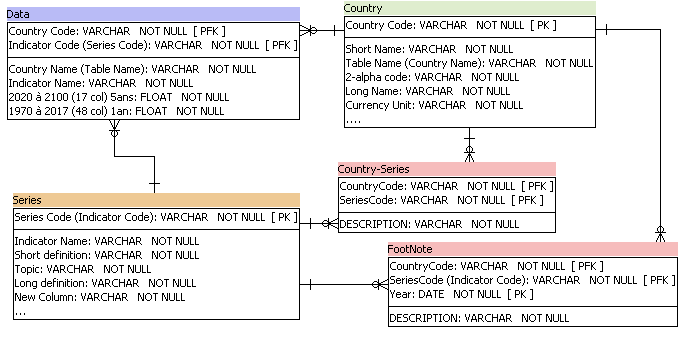

In [28]:
Image("../UML/EduStatsMPD.png")

Les clés proposées dans le MPD ci-dessus pour chaque jeu faciliteraient l'utilisation de la base, sous réserve de quelques modifications (voir modifications plus bas) :
- renommer certaines colonnes afin de lever les ambiguïtés
(ex : Series/"Series Code" -> Series/"Indicator Code")
- supprimer les colonnes redondantes ou inutiles
(ex : Data/"Country Name", accessibles via la clé étrangère "Country Code" en colonne Country/"Table Name")

### 1.1 Données dupliquées ou contradictoires

#### Vérification de l'unicité des clés de chaque table

La description ci-dessus nous a permis de déterminer les colonnes de chaque bases susceptibles de jouer le rôle de clés. Afin de faciliter l'exploitation de la base, il est important que la clé de chaque table soit unique.
Vérifions donc que les tables sont exemptes de doublons :

In [29]:
print("Table Data : Unicité de la clé ('Country Code'&'Indicator Code') {}"\
      .format(uniCle([data["Country Code"], data["Indicator Code"]])))
print("Table Country : Unicité de la clé ('Country Code') {}"\
      .format(uniCle(country["Country Code"])))
print("Table Series : Unicité de la clé ('Series Code') {}"\
      .format(uniCle(series["Series Code"])))
print("Table Country-Series : Unicité de la clé ('CountryCode'&'SeriesCode') {}"\
      .format(uniCle([cnt_ser["CountryCode"], cnt_ser["SeriesCode"]])))
print("Table FootNote : Unicité de la clé ('CountryCode'&'SeriesCode'&'Year') {}"\
      .format(uniCle([footnote["CountryCode"],footnote["SeriesCode"],footnote["Year"]])))

Table Data : Unicité de la clé ('Country Code'&'Indicator Code') True
Table Country : Unicité de la clé ('Country Code') True
Table Series : Unicité de la clé ('Series Code') False
Table Country-Series : Unicité de la clé ('CountryCode'&'SeriesCode') True
Table FootNote : Unicité de la clé ('CountryCode'&'SeriesCode'&'Year') True


Les tables sont bien exemptes de doublons. Pour plus de clarté, on renomme les colonnes contenant des entrées apparentées :

In [30]:
country_c.rename(columns={'Table Name':'Country Name'}, inplace=True)
series_c.rename(columns={'Series Code':'Indicator Code'}, inplace=True)
cnt_ser_c.rename(columns={'CountryCode':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Desc Data'}, inplace=True)
footnote_c.rename(columns={'CountryCode':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Footnote Data'}, inplace=True)

#### Correspondance des entrées uniques des colonnes apparentées

- Les tables "Data" et "Country" n'ont pas le même nombre d'entrée uniques pour la colonne "Country Code" (voir dataframes inf_data et inf_country) : la table "Country" contient un pays en moins. On cherche à déterminer ce pays :

In [31]:
cnt_lack = Diff(list(data["Country Code"].unique()),list(country["Country Code"].unique()))
print("Codes des pays spécifiques à 'Data' : {}"\
  .format(cnt_lack[0]))
print("Codes des pays spécifiques à 'Country' : {}"\
  .format(cnt_lack[1]))
code = list(cnt_lack[0])[0]
nom = list(data[data["Country Code"]==(list(cnt_lack[0])[0])]["Country Name"].unique())[0]
print("Code et nom du pays à ajouter : {},{}".format(code, nom))

Codes des pays spécifiques à 'Data' : {'VGB'}
Codes des pays spécifiques à 'Country' : set()
Code et nom du pays à ajouter : VGB,British Virgin Islands


La table Country étant supposée renseigner sur tous les pays présents dans la base, on rajoute une ligne dans la base "Country" contenant le pays manquant :

In [32]:
line_vgb = pd.DataFrame([[code]+[None]+[nom]+[None]*(country_c.columns.size-3)],\
                        columns = country_c.columns) # ligne à ajouer
country_c = country_c.append(line_vgb,'sort=False') # ajout en bas de la liste
country_c = country_c.sort_values("Country Code") # remet les lignes en ordre alphabétique de pays
country_c.index = list(np.arange(country_c.index.size)) # renumérote l'index

In [33]:
#country_c.drop_duplicates(subset='Country Name', keep='first', inplace=True)

- Les entrées uniques des colonnes "Country Name" et "Table Name" des tables "Data" et "Country" ne correspondent pas :

In [34]:
cnt_lack = Diff(list(data_c["Country Name"].unique()),list(country_c["Country Name"].unique()))

print("* Noms des pays spécifiques à 'Data' : {}"\
  .format(sorted(cnt_lack[0])))
print("----------------")
print("* Noms des pays spécifiques à 'Country' : {}"\
  .format(sorted(cnt_lack[1])))
print("----------------")
print("* Nombre de pays non concordants : {}, {}".format(len(cnt_lack[0]), len(cnt_lack[1])))
# liste complète des codes des pays posant problème (data, puis country) :
l_data = sorted([data_c[data_c["Country Name"]==nom_col].iloc[0]["Country Code"] for nom_col in cnt_lack[0]])
l_country = sorted([country_c[country_c["Country Name"]==nom_col].iloc[0]["Country Code"] for nom_col in cnt_lack[1]])
l_pbe = sorted(list(set(l_data + l_country)))
print("----------------")
print("* Liste des codes des {} pays posant problème : {}".format(len(l_pbe), l_pbe))

* Noms des pays spécifiques à 'Data' : ["Cote d'Ivoire", 'Curacao', 'East Asia & Pacific (excluding high income)', 'Europe & Central Asia (excluding high income)', 'Faroe Islands', 'Korea, Dem. People’s Rep.', 'Latin America & Caribbean (excluding high income)', 'Middle East & North Africa (excluding high income)', 'Sao Tome and Principe', 'Sub-Saharan Africa (excluding high income)']
----------------
* Noms des pays spécifiques à 'Country' : ['Curaçao', "Côte d'Ivoire", 'East Asia & Pacific (all income levels)', 'Europe & Central Asia (all income levels)', 'Faeroe Islands', 'Korea, Dem. Rep.', 'Latin America & Caribbean (all income levels)', 'Middle East & North Africa (all income levels)', 'Sub-Saharan Africa (all income levels)', 'São Tomé and Principe']
----------------
* Nombre de pays non concordants : 10, 10
----------------
* Liste des codes des 15 pays posant problème : ['CIV', 'CUW', 'EAP', 'EAS', 'ECA', 'ECS', 'FRO', 'LAC', 'LCN', 'MEA', 'MNA', 'PRK', 'SSA', 'SSF', 'STP']


In [35]:
# tableau comparatif des noms de pays 'posant problème' et ayant le même code dans data et country
mask1 = [li.any() for li in np.array([np.array((data["Country Code"]==n).values) for n in l_pbe]).T]
mask2 = [li.any() for li in np.array([np.array((country["Country Code"]==n).values) for n in l_pbe]).T]
comp = pd.merge(data[mask1], country[mask2], left_on= "Country Code", right_on= "Country Code")
tab_ser = [comp[comp["Country Code"] == pays].iloc[0][['Country Code','Country Name', 'Table Name']] \
           for pays in l_pbe]
my_df = pd.DataFrame(tab_ser, columns = ['Country Code','Country Name', 'Table Name'])
my_df.columns = ['Country Code','Country Name (data_c)', 'Country Name (country_c)' ]
my_df.sort_values(by = ['Country Name (country_c)'], ascending = True, inplace = True)
my_df = my_df.reset_index(drop=True)
my_df.head()

,Country Code,Country Name (data_c),Country Name (country_c)
0,CUW,Curacao,Curaçao
1,CIV,Cote d'Ivoire,Côte d'Ivoire
2,EAP,East Asia & Pacific (excluding high income),East Asia & Pacific
3,EAS,East Asia & Pacific,East Asia & Pacific (all income levels)
4,ECA,Europe & Central Asia (excluding high income),Europe & Central Asia


On conserve les noms de la table 'Data', qui ne contiennent pas de caractères spéciaux, et qui sont plus clairs sur la désignation ('excluding high income' préférable à 'all income levels') :

In [36]:
country_c["Country Name"].replace(to_replace = my_df['Country Name (country_c)'].values, \
                       value = my_df['Country Name (data_c)'].values, inplace=True)

- Les tables "Data" et "Series" ont bien le même nombre d'entrée uniques pour la colonne "Indicator Code" et "Series Code" (voir dataframes inf_data et inf_country) : 3665. Vérifions si ces entrées uniques sont bien les mêmes :

In [37]:
serie_lack = Diff(list(data_c["Indicator Code"].unique()),list(series_c["Indicator Code"].unique()))

print("Nbe d'indicateurs spécifiques à 'Data' : {}"\
  .format(len(serie_lack[0])))
print("Nbe d'indicateurs spécifiques à 'Series' : {}"\
  .format(len(serie_lack[1])))
print("Quelques indicateurs spécifiques à 'Data' :\n {}"\
  .format(sorted(serie_lack[0])[:5]))
print("Quelques indicateurs spécifiques à 'Series' :\n {}"\
  .format(sorted(serie_lack[1])[:5]))

Nbe d'indicateurs spécifiques à 'Data' : 53
Nbe d'indicateurs spécifiques à 'Series' : 53
Quelques indicateurs spécifiques à 'Data' :
 ['SE.SEC.DURS.LO', 'SE.SEC.ENRR.UP.FE', 'UIS.AIR.1.GLAST.GPI', 'UIS.CEAGE.1', 'UIS.E.0.PU.F']
Quelques indicateurs spécifiques à 'Series' :
 ['SE.SEC.DURS.LO ', 'SE.SEC.ENRR.UP.FE ', 'UIS.AIR.1.Glast.GPI', 'UIS.CEAge.1', 'UIS.E.0.Pu.F']


L'échantillon d'indicateurs affichés ci-dessus ne diffèrent en fait que par 1) des espaces 2) des lettres en minuscule dans la table "Series". Vérifions qu'après correction les entrées sont les mêmes :

In [38]:
test_ser = pd.Series([series["Series Code"][i].upper().replace(" ", "")\
                for i in range(series["Series Code"].index.size)],\
                 index = series["Series Code"].index)
test_data = pd.Series([data["Indicator Code"][i].upper().replace(" ", "")\
                for i in range(data["Indicator Code"].index.size)],\
                 index = data["Indicator Code"].index)
lack1 = Diff(list(data["Indicator Code"].unique()),list(test_ser.unique()))
lack2 = Diff(list(test_data.unique()), list(series["Series Code"].unique()))
lack3 = Diff(list(test_data.unique()), list(test_ser.unique()))

print("-----Correction de 'Series' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack1[0]), len(lack1[1])))
print("-----Correction de 'Data' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack2[0]), len(lack2[1])))
print("-----Correction de 'Data' et 'Series' :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack3[0]), len(lack3[1])))

-----Correction de 'Series' seule :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 5, 5
-----Correction de 'Data' seule :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 58, 58
-----Correction de 'Data' et 'Series' :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 0, 0


La correction des noms des deux bases est nécessaire. On effectue la correction des indicateurs dans la base 'Data', dans la base 'Series'.

In [39]:
data_c["Indicator Code"].replace(to_replace = serie_lack[0], \
                        value = [x.upper().replace(" ", "") for x in serie_lack[0]], inplace=True)
series_c["Indicator Code"].replace(to_replace = serie_lack[1], \
                             value =[x.upper().replace(" ", "") for x in serie_lack[1]], inplace=True)

In [40]:
serie_lack2 = Diff(list(data_c["Indicator Code"].unique()),list(series_c["Indicator Code"].unique()))
print("Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : {}, {}"\
      .format(len(serie_lack2[0]),len(serie_lack2[1])))

Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : 0, 0


- Vérifions que les codes d'indicateurs et de pays présents dans les tables "Country-Series" et "Footnote" sont bien dans la liste des codes d'indicateurs de la table "Series" et dans la liste des codes de pays de la table "Country" :

In [41]:
cnt_ser_lack1 = Diff(list(series_c["Indicator Code"].unique()),list(cnt_ser_c["Indicator Code"].unique()))
cnt_ser_lack2 = Diff(list(country_c["Country Code"].unique()),list(cnt_ser_c["Country Code"].unique()))
footnote_lack1 = Diff(list(series_c["Indicator Code"].unique()),list(footnote_c["Indicator Code"].unique()))
footnote_lack2 = Diff(list(country_c["Country Code"].unique()),list(footnote_c["Country Code"].unique()))

print("-------- table 'CountrySeries' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(cnt_ser_lack1[0]), len(cnt_ser_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'CountrySeries' : {}/{}"\
  .format(len(cnt_ser_lack1[1]), len(cnt_ser_lack2[1])))
print("-------- table 'FootNote' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(footnote_lack1[0]), len(footnote_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'FootNote' : {}/{}"\
  .format(len(footnote_lack1[1]), len(footnote_lack2[1])))

-------- table 'CountrySeries' --------
Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : 3644/31
Nbe d'indicateurs/de pays spécifiques à 'CountrySeries' : 0/0
-------- table 'FootNote' --------
Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : 2196/3
Nbe d'indicateurs/de pays spécifiques à 'FootNote' : 89/0


La base 'CountrySeries' ne contient ni de code de pays ni de code d'indicateur qui ne soit pas dans les bases 'Country' et 'Series', en revanche, la base 'FootNote' contient des codes d'indicateurs erronnés.

In [42]:
print("-------------")
# pays pas dans footnote, 
#print("Quelques code pays seulement dans footnote :\n{}".format(list(footnote_lack2[0])[:15]))

#pays seulement dans footnote
print("Quelques code pays seulement dans footnote :\n{}".format(list(footnote_lack2[1])[:5]))

print("-------------")
# codes indicateurs pas dans footnote,
#print("Quelques indicateurs de 'series' pas dans 'footnote' :\n{}".format(list(footnote_lack1[0])[:3]))

#codes indicateurs seulement dans footnote
print("Quelques indicateurs seulement dans 'footnote' :\n{}".format(list(footnote_lack1[1])[:25]))

-------------
Quelques code pays seulement dans footnote :
[]
-------------
Quelques indicateurs seulement dans 'footnote' :
['UIS.LP.Ag15t99.F', 'UIS.XGovExp.IMF.23', 'UIS.XUNIT.PPP.2.FSgov', 'UIS.LR.Ag65.GPI', 'UIS.LP.Ag65.F', 'se.ADT.1524.LT.FM.ZS', 'UIS.XGDP.23.FSgov', 'UIS.XSpendP.23.FDpub.FNs', 'UIS.XSpendP.1.FDpub.FNcap', 'UIS.XUNIT.GDPcap.2.FSgov', 'UIS.XSpendP.FDpub.FNcap', 'UIS.XUNIT.PPPconst.4.FSgov', 'UIS.E.0.Pu.F', 'UIS.LP.Ag65', 'UIS.XUNIT.PPP.3.FSgov', 'UIS.XSpendP.FDpub.FNs', 'UIS.E.1.Guk', 'UIS.SR.1.Glast.GPI', 'UIS.LR.Ag15t99.GPI', 'UIS.XGovExp.IMF.1', 'UIS.XSpendP.3.FDpub.FNcur', 'se.ADT.1524.LT.FE.ZS', 'UIS.XUNIT.PPP.4.FSgov', 'UIS.LP.Ag15t99', 'UIS.GER.1t6.M']


Les codes d'indicateurs de 'FootNote' contiennent des lettres en minuscules. On applique la même modification que pour les tables 'Data' et 'Series' précédemment (élimination des espaces, passage en majuscules). On vérifie qu'après correction 'FootNote' n'a pas de codes d'indicateurs spécifiques.

In [43]:
footnote_c["Indicator Code"].replace(to_replace = footnote_lack1[1], \
                        value = [x.upper().replace(" ", "") for x in footnote_lack1[1]], inplace=True)
footnote_lack = Diff(list(footnote_c["Indicator Code"].unique()),list(series_c["Indicator Code"].unique()))
print("Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : {}, {}"\
      .format(len(footnote_lack[0]),len(footnote_lack[1])))

Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : 0, 2183


* Y a-t-il une correspondance entre les noms d'indicateurs de la table "Series" et ceux de la table "Data" ? Si oui, comme pour les noms de pays, on ne gardera qu'une des deux colonnes.

On remarque que 462 entrées uniques de la colonne "Indicator Name" de la table "data" ne sont pas dans la table "series" et que le même nombre 462 d'entrées uniques de la même colonne de la table "series" ne sont pas dans la table "data".

In [44]:
indic_lack = Diff(list(data_c["Indicator Name"].unique()),list(series["Indicator Name"].unique()))
#noms d'indicateurs seulement dans data
print("Quelques indicateurs seulement dans 'Data' :\n{}".format(list(indic_lack[0])[:3]))
#noms d'indicateurs seulement dans series
print("Quelques indicateurs seulement dans 'Series' :\n{}".format(list(indic_lack[1])[:3]))
print("----------------")
print("* Nombre de pays non concordants : {}, {}".format(len(indic_lack[0]), len(indic_lack[1])))
# liste complète des codes des indicateurs posant problème (data, puis series) :
l_data = sorted([data_c[data_c["Indicator Name"]==nom_col].iloc[0]["Indicator Code"] for nom_col in indic_lack[0]])
l_series = sorted([series_c[series_c["Indicator Name"]==nom_col].iloc[0]["Indicator Code"] for nom_col in indic_lack[1]])
l_pbe = sorted(list(set(l_data + l_series)))
print("----------------")
print("* Liste des codes de quelques-uns des {} indicateurs posant problème : {}".format(len(l_pbe), l_pbe[:3]))

Quelques indicateurs seulement dans 'Data' :
['LLECE: Mean performance on the mathematics scale for 3rd grade students, female', 'Wittgenstein Projection: Mean years of schooling. Age 15-19. Male', 'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Male']
Quelques indicateurs seulement dans 'Series' :
['Projection: Percentage of the total population by highest level of educational attainment. Primary. Total', 'Projection: Population in thousands by highest level of educational attainment. No Education. Total', 'Projection: Percentage of the population age 80+ by highest level of educational attainment. Post Secondary. Female']
----------------
* Nombre de pays non concordants : 462, 462
----------------
* Liste des codes de quelques-uns des 462 indicateurs posant problème : ['LO.LLECE.MAT3', 'LO.LLECE.MAT3.FE', 'LO.LLECE.MAT3.MA']


In [45]:
# tableau comparatif des noms de pays 'posant problème' et ayant le même code dans data et series
mask1 = [li.any() for li in np.array([np.array((data_c["Indicator Code"]==n).values) for n in l_pbe]).T]
mask2 = [li.any() for li in np.array([np.array((series_c["Indicator Code"]==n).values) for n in l_pbe]).T]
comp = pd.merge(data_c[mask1], series_c[mask2], left_on= "Indicator Code", right_on= "Indicator Code")
tab_ser = [comp[comp["Indicator Code"] == ind].iloc[0][['Indicator Code','Indicator Name_x', 'Indicator Name_y']] \
           for ind in l_pbe]

In [46]:
# Affichage des noms complets
# comp[['Indicator Code','Indicator Name_x', 'Indicator Name_y', 'Country Name']]\
# .groupby(['Indicator Code','Indicator Name_x','Indicator Name_y']).count()

In [47]:
my_df = pd.DataFrame(tab_ser, columns = ['Indicator Code','Indicator Name_x', 'Indicator Name_y'])
my_df.columns = ['Indicator Code','Indicator Name (data_c)', 'Indicator Name (series_c)' ]
my_df.sort_values(by = ['Indicator Name (series_c)'], ascending = True, inplace = True)
#my_df = my_df.reset_index(drop=True)
my_df.head()

,Indicator Code,Indicator Name (data_c),Indicator Name (series_c)
12342,SP.POP.AG00.FE.UN,"Population, age 0, female","Age population, age 0, female, UNESCO"
12584,SP.POP.AG00.TO.UN,"Population, age 0, total","Age population, age 0, total, UNESCO"
12826,SP.POP.AG01.FE.UN,"Population, age 1, female","Age population, age 01, female, UNESCO"
13068,SP.POP.AG01.TO.UN,"Population, age 1, total","Age population, age 01, total, UNESCO"
18150,SP.POP.AG02.FE.UN,"Population, age 2, female","Age population, age 02, female, UNESCO"


Les noms de la table 'Series' sont généralement plus complets que ceux de 'Data'. On remplace donc les valeurs de 'Indicator Name' dans 'data_c' par celles de la même colonne dans 'series_c' : 

In [48]:
############# A FAIRE  #########################
# Remplacement par le nom le plus long des deux
# Vérifier quand même que des indicateurs plus courts n'ont pas été remplacés par des plus longs !!!!
#################################################""""""

In [49]:
# remplacement des noms de la colonne data, par ceux de la colonne series
data_c["Indicator Name"].replace(to_replace = my_df['Indicator Name (data_c)'].values, \
                        value = my_df['Indicator Name (series_c)'].values, inplace=True)

In [50]:
#Vérification de la correspondance après modification
verif = Diff(sorted(data_c["Indicator Name"].unique()), sorted(series_c["Indicator Name"].unique()))
list(verif[0])[:5], list(verif[1])[:5]

([], [])

In [51]:
len(data_c["Indicator Name"].unique()), len(series_c["Indicator Name"].unique())

(3665, 3665)

#### Simplification de la base

In [52]:
############# A FAIRE  #########################
# Fusion des tables footnote_c et cnt_ser_c en une table inf_data_c
#################################################

* Les années de la table "FootNote" sont apparemment dans un format string et précédés de YR ou yr.

In [53]:
# liste des années de la colonne "Year" de la table "FootNote"
print(set(footnote_c["Year"].unique()))

{'YR2015', 'YR1972', 'YR1994', 'YR1980', 'YR1987', 'YR1985', 'YR2008', 'YR2045', 'YR2035', 'YR2020', 'YR1977', 'YR2001', 'YR1984', 'YR1997', 'YR2004', 'YR1989', 'YR1993', 'YR2002', 'YR2009', 'YR1983', 'YR2003', 'YR2012', 'YR1970', 'YR1973', 'YR1992', 'YR1981', 'YR2007', 'YR1971', 'YR2013', 'YR1995', 'YR2030', 'YR1996', 'YR1979', 'YR2016', 'YR1988', 'YR2017', 'YR2014', 'YR1986', 'YR2025', 'YR1976', 'YR2000', 'YR1990', 'YR2050', 'YR2011', 'YR2040', 'YR2010', 'YR1998', 'YR1975', 'YR2006', 'YR2005', 'YR1982', 'YR1974', 'YR1991', 'yr2012', 'YR1978', 'YR1999'}


On remplace les valeurs des chaînes par l'entier correspondant :

In [54]:
# remplacement des années de la colonne 'Year', par les nombres correspondants
ch_ann_uni = list(footnote_c["Year"].unique())
int_ann_uni = [int(('').join(re.findall("[0-9]", chaine))) for chaine in ch_ann_uni]
footnote_c["Year"].replace(to_replace = ch_ann_uni, value = int_ann_uni, inplace=True)

In [55]:
print(set(footnote_c["Year"].unique()))

{2050, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2020, 2025, 2030, 2035, 2040, 2045}


#### Relations bijectives entre colonnes d'une même base

Après vérification de l'unicité des clés choisies pour chaque table, on vérifie la correspondance bijective entre plusieurs paires de colonnes d'une même table, par exemple :
 - les codes de pays et les noms de pays (dans 'Data' et dans 'Country')
 - les codes d'indicateurs et les noms d'indicateurs (dans 'Data' et dans 'Series')

On teste (voir définition de la fonction 'Adeq' plus haut) les couples de colonnes listés ci-dessous :
- Table "Data" : "Country Code", "Country Name" ( Dataframe "data_c" : "Country Code", "Country Name" )
- Table "Data" : "Indicator Code", "Indicator Name" ( Dataframe "data_c" : "Indicator Code", "Indicator Name" )
- Table "Country" : "Country Code", "Short Name" ( Dataframe "country_c" : "Country Code", "Short Name" )
- Table "Country" : "Country Code", "Table Name" ( Dataframe "country_c" : "Country Code", "Country Name" )
- Table "Country" : "Country Code", "Long Name" ( Dataframe "country_c" : "Country Code", "Long Name" )
- Table "Series" : "Series Code", "Indicator Name" ( Dataframe "series_c" : "Indicator Code", "Indicator Name" )

In [56]:
print("Data : {} {}"\
      .format(Adeq(data_c, "Country Code", "Country Name"), Adeq(data_c, "Indicator Code", "Indicator Name")))
print("Country : {} {} {}"\
      .format(Adeq(country_c, "Country Code", "Short Name"), Adeq(country_c, "Country Code", "Country Name"),\
        Adeq(country_c, "Country Code", "Long Name")))
print("Series : {}".format(Adeq(series_c, "Indicator Code", "Indicator Name")))

Data : True True
Country : True True True
Series : True


#### Ajout à la table 'Data'
Pour faciliter le traitement ultérieur des données de la table "Data", on ajoute deux colonnes précisant :
- la région du pays 
- et le topic de l'indicateur

In [57]:
# ajout de la région du pays
data_c = pd.merge( data_c , country_c[['Country Code', 'Region']] , left_on = 'Country Code', right_on = 'Country Code' )
# ajout du topic de l'indicateur
data_c = pd.merge( data_c , series_c[['Indicator Code', 'Topic']] , left_on = 'Indicator Code', right_on = 'Indicator Code' )
cols = list(data_c.columns.values)
cols = cols[-2:]+cols[:-2]
data_c = data_c[cols] # remise en ordre des colonnes

#### Elimination des colonnes sous-remplies

Il existe des colonnes dans les tables 'Country', 'Series', 'Country-Series' et 'Footnote' qui sont très peu remplies. Cependant, les données contenues dans ces tables ne sont pas indispensables au traitement des données chiffrées, qui sont contenues dans la table 'Data'. On n'éliminera donc pas ces colonnes.
En ce qui concerne la table 'Data', elle contient seulement deux colonnes peu remplies (années 2016 et 2017) qu'il n'est pas nécessaire d'effacer pour l'instant.

#### Groupes de pays en régions

* Dans la liste country_c["Country Name"], on remarque 27 pays n'ayant pas de valeur de country["Region"] et country["Income group"]. Ceux-ci sont en fait des groupes de pays. On élimine les données relatives à ces pays (data_c) de notre liste d'intérêt.

In [58]:
# comptage des pays uniques sans région
sans_reg_cnt = country_c[country_c["Region"].isna()]["Country Name"]
li_pays_supp = sans_reg_cnt.values
#['Arab World', 'East Asia & Pacific (excluding high income)','East Asia & Pacific', 'Europe & Central Asia (excluding high income)', 'Europe & Central Asia', 'Euro area', 'European Union', 'Gibraltar', 'High income', 'Heavily indebted poor countries (HIPC)', 'Latin America & Caribbean (excluding high income)', 'Latin America & Caribbean', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Low & middle income', 'Middle East & North Africa', 'Middle income', 'Middle East & North Africa (excluding high income)', 'North America', 'Nauru', 'OECD members', 'South Asia', 'Sub-Saharan Africa (excluding high income)', 'Sub-Saharan Africa', 'Upper middle income', 'British Virgin Islands', 'World']
print(Diff(sans_reg_cnt, sans_reg_cnt) , len(sans_reg_cnt))
print(li_pays_supp) # faux 'pays' à éliminer

(set(), set()) 28
['Arab World' 'East Asia & Pacific (excluding high income)'
 'East Asia & Pacific' 'Europe & Central Asia (excluding high income)'
 'Europe & Central Asia' 'Euro area' 'European Union' 'Gibraltar'
 'High income' 'Heavily indebted poor countries (HIPC)'
 'Latin America & Caribbean (excluding high income)'
 'Latin America & Caribbean'
 'Least developed countries: UN classification' 'Low income'
 'Lower middle income' 'Low & middle income' 'Middle East & North Africa'
 'Middle income' 'Middle East & North Africa (excluding high income)'
 'North America' 'Nauru' 'OECD members' 'South Asia'
 'Sub-Saharan Africa (excluding high income)' 'Sub-Saharan Africa'
 'Upper middle income' 'British Virgin Islands' 'World']


In [59]:
# élimination des faux 'pays' dans "Country"
ind_supp_cnt = sans_reg_cnt.index # index des lignes du tableau country à éliminer (une seule par nom)
country_c.drop(index = ind_supp_cnt, inplace = True)
# élimination des faux 'pays' dans "Data"
sans_reg_data = [data_c[data_c["Country Name"]== col].index for col in li_pays_supp] # liste de listes d'index à retirer
ind_supp_data = [item for sublist in sans_reg_data for item in sublist] # liste des index (applatie)
data_c.drop(index = ind_supp_data, inplace = True)

In [60]:
# vérification
sans_reg_cnt = country_c[country_c["Region"].isna()]["Country Name"]
len(sans_reg_cnt)
sans_reg_cnt = country_c[country_c["Region"].isna()]["Country Name"]
sans_reg_data = data_c[data_c["Region"].isna()]["Country Name"]
print(len(sans_reg_cnt))

0


### 1.2 Données manquantes
#### Comptage des données manquantes par table

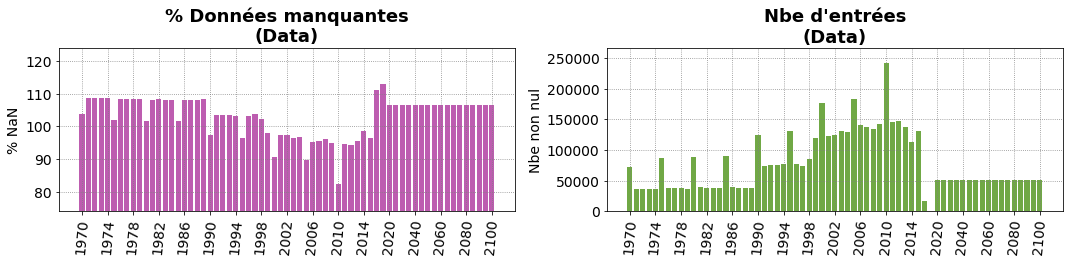

In [61]:
fig = plt.figure(figsize = (18,3))

colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]

li_annees = inf_data.columns[4:]
x=li_annees
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_data[li_annees].loc["null"]*100/data_c.shape[0] # % de valeurs nulles
y2=inf_data[li_annees].loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab[::4], "", "% NaN",  "% Données manquantes\n(Data)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab[::4], "", "Nbe non nul",  "Nbe d'entrées\n(Data)", 1)

plt.show()

In [62]:
# nbe de remplissage minimum/maximum et année correspondante
sel_data = inf_data.loc["count"][4:]
val_min = sel_data.min()
val_max = sel_data.max()

print("- année nbe entrées min, nbe entrées min : \n{}, \n{:.0f}, soit {:.3f}%"\
      .format(sel_data.index[sel_data==val_min], \
              val_min, val_min*100/(data.shape[0])))

print("- année nbe entrées max, nbe entrées max : \n{}, \n{:.0f}, soit {:.3f}%"\
     .format(sel_data.index[sel_data==val_max], \
             val_max, val_max*100/(data.shape[0])))

- année nbe entrées min, nbe entrées min : 
Index(['2017'], dtype='object'), 
143, soit 0.016%
- année nbe entrées max, nbe entrées max : 
Index(['2010'], dtype='object'), 
242442, soit 27.335%


- La table "Data" donnant la valeur d'un indicateur pour une année comporte environ 86 % de données non renseignées.
- Environ 60% de l'ensemble des couples Indicateur/Pays n'a aucune valeur renseignée.
- L'année la mieux renseignée est l'année 2010 (27% des couples Indicateur/Pays, soit plus de 242 000 valeurs), et les moins renseignées sont les années 2016 et 2017 (respectivement 1,8% et 0,016% des couples, soit 16460 et 143 valeurs)

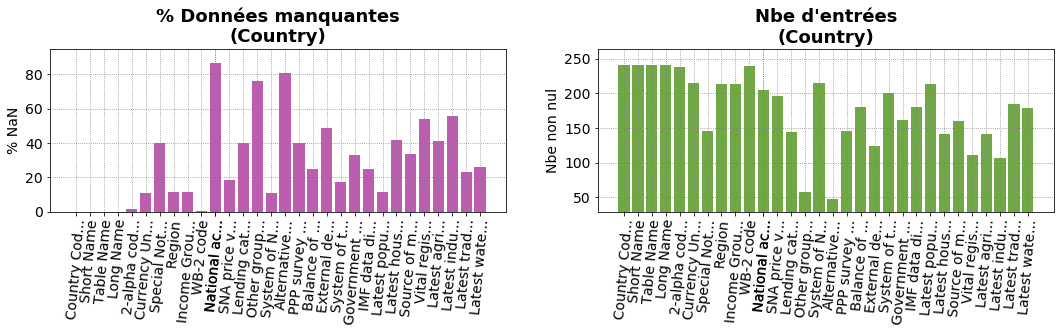

In [63]:
fig = plt.figure(figsize = (18,3))

x=inf_country.columns
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_country.loc["null"]*100/country.shape[0]  # % de valeurs nulles
y2=inf_country.loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab, "", "% NaN",  "% Données manquantes\n(Country)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab, "", "Nbe non nul",  "Nbe d'entrées\n(Country)", 1)

plt.show()

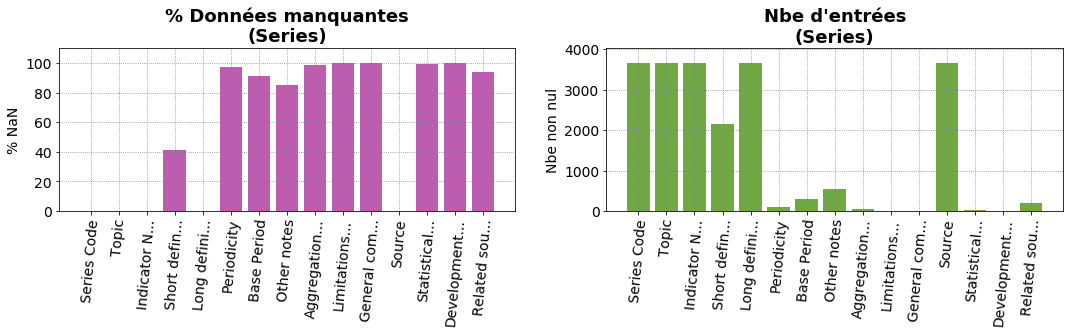

In [64]:
fig = plt.figure(figsize = (18,3))

x=inf_series.columns
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_series.loc["null"]*100/series.shape[0]  # % de valeurs nulles
y2=inf_series.loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab, "", "% NaN",  "% Données manquantes\n(Series)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab, "", "Nbe non nul",  "Nbe d'entrées\n(Series)", 1)

plt.show()

In [65]:
print("la table 'CountrySeries' contient {} entrées nulles".format(inf_cnt_ser.loc["null"].sum()))
print("la table 'FootNote' contient {} entrées nulles".format(inf_footnote.loc["null"].sum()))

la table 'CountrySeries' contient 0 entrées nulles
la table 'FootNote' contient 0 entrées nulles


* Nombre de pays par région, et d'indicateurs par topic

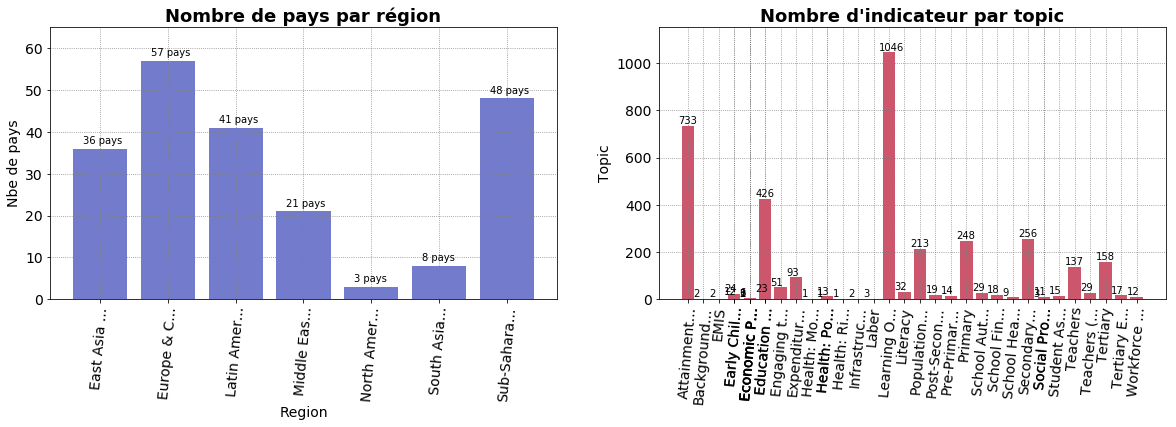

In [66]:
fig = plt.figure(figsize = (20,5))
#fig, (plot1, plot2) = plt.subplots(1, 2, figsize = (18,6), gridspec_kw={'width_ratios': [2, 5]})

df1 = country_c[['Country Name', 'Region']].groupby('Region').count()
df2 = series_c[['Indicator Name', 'Topic']].groupby('Topic').count()
li_region = list(df1.index)
li_topic = list(df2.index)
x1 = li_region
xlab1 = [my_str[:10]+"..." if len(my_str)>8 else my_str for my_str in x1]
x2 = li_topic
xlab2 = [my_str[:10]+"..." if len(my_str)>8 else my_str for my_str in x2]
y1 = df1.values.reshape(len(df1.values),)
y2 = df2.values.reshape(len(df2.values),)

# Nombre de pays par région
plot1 = plt.subplot(1,2,1)
#basic_plot("bar", plot1, xlab1, y1, xlab1, "", "Région",  "Nombre de pays par région", 5)

plot1.bar(xlab1, y1, color = colors[1])
plot1.bar(xlab1, y1, color = colors[2])
plot1.set_xlabel("Region", fontsize = 14), plot1.set_ylabel("Nbe de pays", fontsize = 14)
plt.xticks(xlab1, xlab1, rotation=85 , fontsize = 14), plt.yticks(fontsize = 14)
plt.ylim(round(min(y1)*0.9), round(max(y1)*1.1)) 
plot1.set_title("Nombre de pays par région", fontsize = 18, fontweight = 'bold')
plt.grid(color='grey', linestyle='dotted')

labels = [ '{:.0f} pays'.format(y1[i]) for i in range(len(y1))] 
for label,xlab1, y1 in zip(labels, xlab1, y1):
    plt.annotate(label, xy=(xlab1, y1), xytext=(-17, 3),
        textcoords='offset points', ha='left', va='bottom' )
plt.ylim(0,65)

# Nombre d'indicateurs par topic
plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab2, y2, xlab2, "", "Topic",  "Nombre d'indicateur par topic", 4)
#plot2 = plt.bar(xlab2, y2)
labels = [ '{:.0f}'.format(y2[i]) for i in range(len(y2))] 
for label,xlab2, y2 in zip(labels, xlab2, y2):
    plt.annotate(label, xy=(xlab2, y2), xytext=(-10, 0),rotation = 0, textcoords='offset points', ha='left', va='bottom' )
#plt.ylim(0,65)

plt.show()

## 2. Exploration des données

Les indicateurs qui nous intéressent sont ceux des dernières années.
On cherche à savoir :
- combien d'indicateurs environ sont disponibles dans les dernières années
- quels sont les pays qui ont le plus d'indicateurs disponibles dans les dernières années
- quels sont les indicateurs le plus souvent disponible 

### Nombres d'indicateurs disponibles par pays et par année

#### Vision globale

Pour avoir une idée de la proportion des indicateurs renseignés, on trace la carte de densité du nombre d'indicateur par pays et par année :

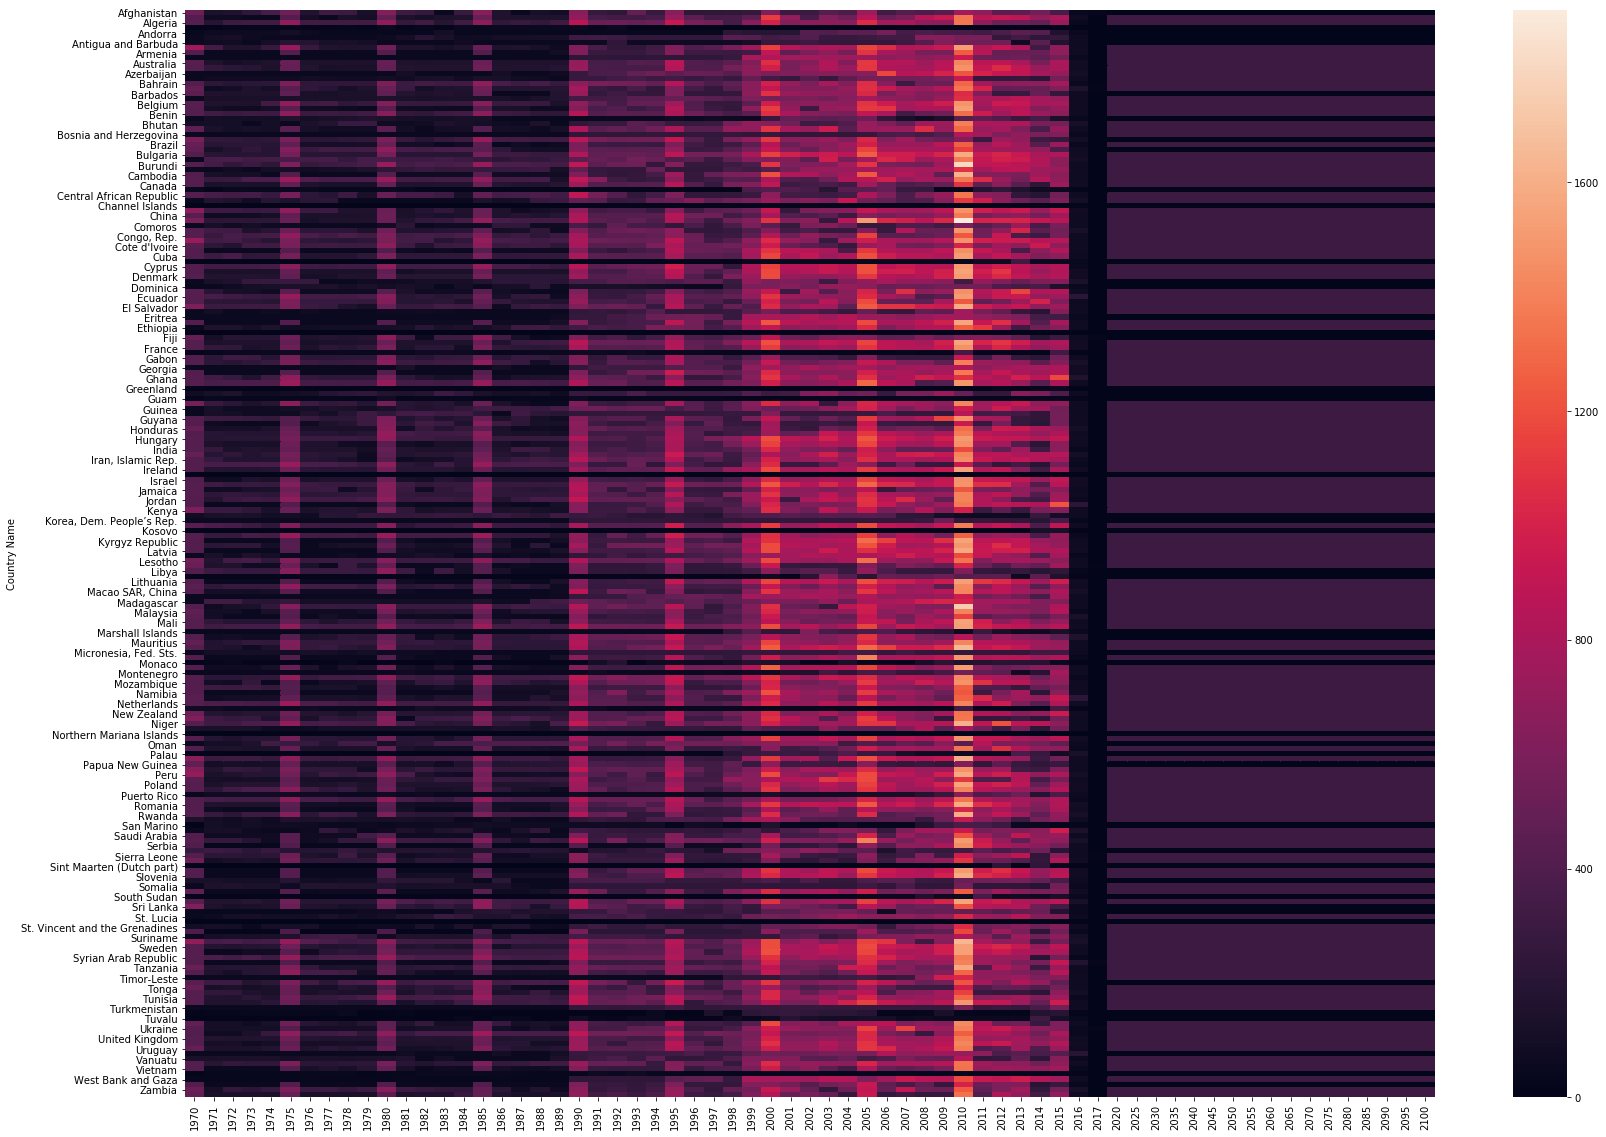

In [67]:
### Heatmap du nombre d'indicateurs non nuls (pays/années)

nb_ind_cnt = data_c.groupby(['Country Name']).count()[li_annees]

# Tableau des nombres d'indicateurs dispo pour chaque pays et chaque année 
fig = plt.figure(figsize = (28,20))
heat_map = sns.heatmap(nb_ind_cnt)

* Certains pays ont peu d'indicateurs, quelles que soient les années considérées (lignes sombres).
* Certaines années sont mieux renseignées (années multiples de 5)
* On distingue plusieurs plages de temps,
    - [1970,1989] : peu renseigné
    - [1990,1999] : assez bien renseigné
    - [2000,2015] : bien renseigné
    - [2016,2019] : quasiment pas renseigné

#### Exploration en vue de la suppression de colonnes (années) et lignes (pays) sous-remplis ou inutiles

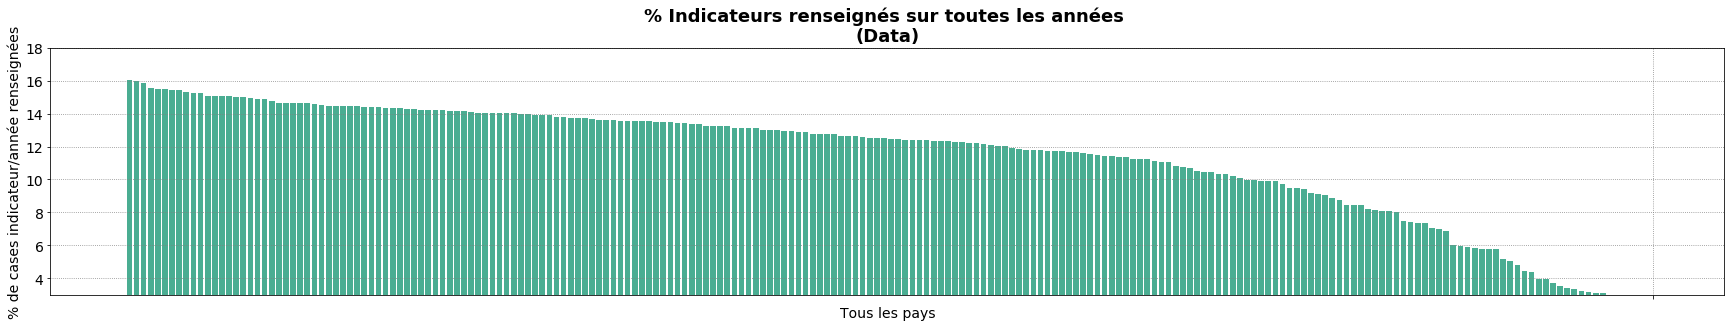

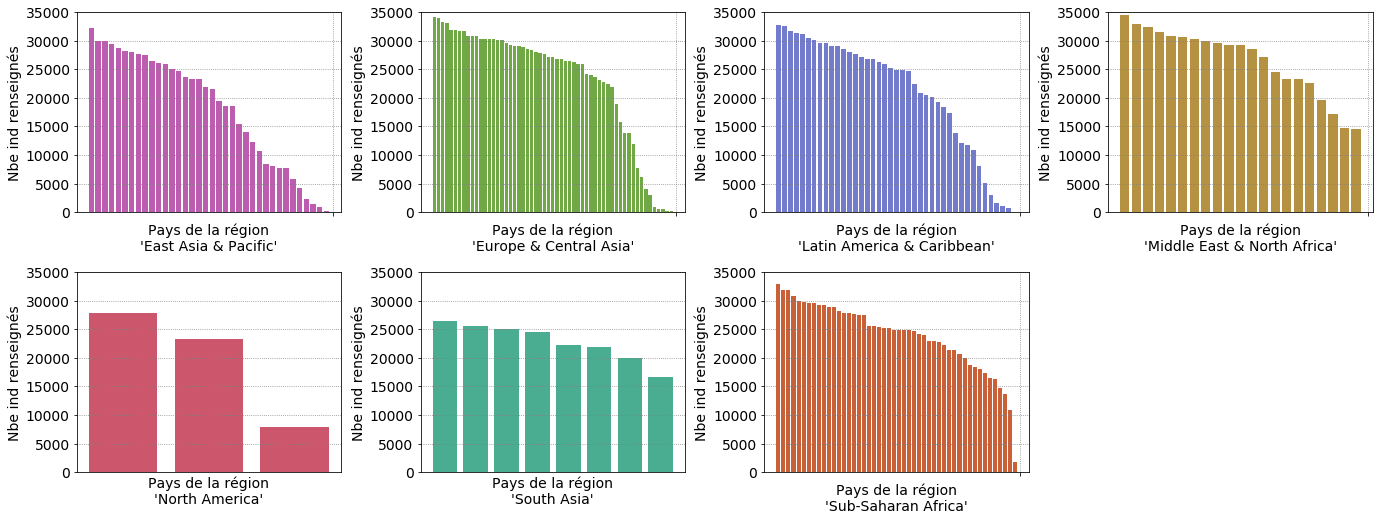

In [68]:
# tableau du pourcentage d'indicateurs renseignés par pays ()

fig1 = plt.figure(figsize = (30,10))
gp = data_c.groupby(['Country Name']).count()
nb_col_an = data_c[4:].shape[1]
nb_indic = series_c['Indicator Code'].shape[0]
nb_max = (nb_col_an*nb_indic)
tab = gp[gp.columns[3:]].sum(axis=1)*100/nb_max
tab.sort_values(ascending=False,inplace=True)

x=tab.index
xlab=[my_str[:8]+"..." if len(my_str)>8 else my_str for my_str in x]
y=tab
plot1 = plt.subplot(2,1,1)
basic_plot("bar", plot1, xlab, y, '', "Tous les pays", "% de cases indicateur/année renseignées",  "% Indicateurs renseignés sur toutes les années \n(Data)", 5)
plt.show()

# tableau du pourcentage d'indicateurs renseignés par pays et par région ()

fig2 = plt.figure(figsize = (30,10))
tab_df = [data_c.groupby(['Region', 'Country Name']).count().loc[reg][li_annees] for reg in li_region]
n = 4 # nombre de colonnes d'affichage en largeur
tab_plot = []
for i in range(len(tab_df)):
    x=tab_df[i].index
    xlab=[my_str[:8]+"..." if len(my_str)>8 else my_str for my_str in x]
    y=tab_df[i].sum(axis=1) # nombre d'indicateurs renseignés
    y.sort_values(ascending=False,inplace=True)
    tab_plot.append(plt.subplot((len(tab_df)+1)//n+1,n,i+1))
    basic_plot("bar", tab_plot[i], xlab, y, '', "Pays de la région\n'"+ li_region[i] + "'", "Nbe ind renseignés",  "", i)
    plt.ylim(0,35000)
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.2, right = 0.7, top = 1.2, wspace = 0.3, hspace = 0.3)
plt.show()

Quelle que soit la région considérée, la plupart des pays ont plus de 5000 indicateurs renseignés, toutes années confondues.

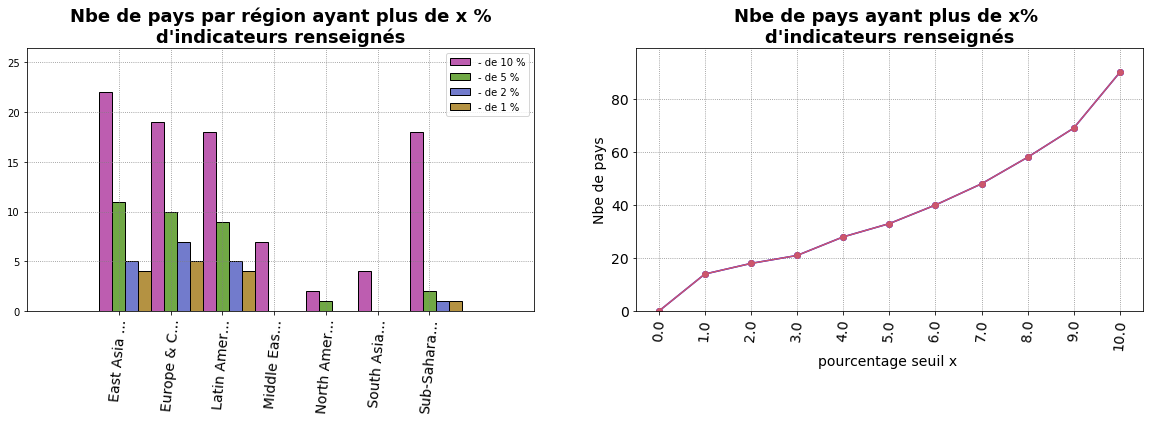

In [69]:
 # Pays ayant moins de pct*100 % d'indicateurs renseignés, par région

def nbe_pays_inf_pct (pct) :
    return [tab_df[i][tab_df[i].sum(axis=1)<pct*(3665*len(li_annees))].shape[0] for i in range(len(li_region))]

fig = plt.figure(figsize = (20,5))

plot1 = plt.subplot(1,2,1)
barWidth = 0.25
x = li_region
xlab = [my_str[:10]+"..." if len(my_str)>8 else my_str for my_str in x]
i=0
for pct in [0.1,0.05,0.02,0.01] :
    plot1.bar(np.arange(len(xlab))+i*barWidth, nbe_pays_inf_pct(pct),\
              color=colors[i], width=barWidth, ec='k', label = "- de %.0f"%(pct*100) + " %")
    i+=1
plt.xticks([r + barWidth for r in range(len(xlab))], xlab, rotation=85 , fontsize = 14)
#plot1.set_xlabel(fontsize = 14), plot1.set_ylabel(fontsize = 14)
plot1.set_title("Nbe de pays par région ayant plus de x %\nd'indicateurs renseignés", fontsize = 18, fontweight = 'bold')
plt.grid(color='grey', linestyle='dotted'), plt.legend()
plt.margins(0.2), plt.subplots_adjust(bottom=0.15)

plot2 = plt.subplot(1,2,2)
x = np.linspace(0,10, 11)
y = [sum(nbe_pays_inf_pct(val/100)) for val in x]
plot2.plot(x,y, '-o', color = 'b')
basic_plot("plot", plot2, x, y, x, "pourcentage seuil x ",\
           "Nbe de pays",  "Nbe de pays ayant plus de x% \nd'indicateurs renseignés" , i)
plt.show()

On pourrait enlever les pays qui ont moins de 2% de leurs indicateurs remplis (moins de 20 pays).

(100000, 364715.4)

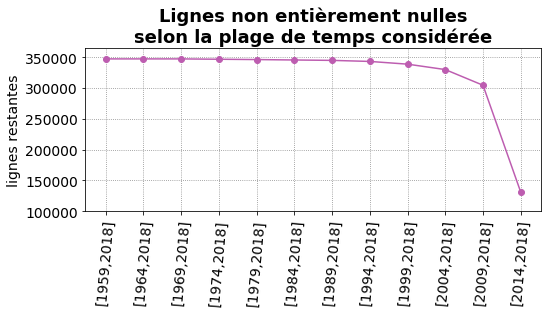

In [70]:
# Nombre de lignes restantes (non entièrement vides) après sélection des années

borne_annee_min = [1959,1964,1969,1974,1979,1984,1989,1994,1999,2004,2009,2014]
y=[]
for annee_min in borne_annee_min:
    new_li_annees = [annee for annee in list(li_annees) if int(annee)>annee_min and int(annee)<2018]
    y.append(data_c[new_li_annees].dropna(how = 'all', inplace = False).shape[0])

fig = plt.figure(figsize = (18,3))

x=borne_annee_min
xlab=["["+str(annee)+",2018]" for annee in x]

plot1 = plt.subplot(1,2,1)
basic_plot("plot", plot1, xlab, y, xlab, "", "lignes restantes", \
           "Lignes non entièrement nulles\nselon la plage de temps considérée", 0)
plot1.set_ylim(100000,data_c[li_annees].dropna(how = 'all', inplace = False).shape[0]*1.05)

La part de la population ayant entre 25 et 26 ans aujourd'hui est née entre 1993 et 1994. Pour notre étude, il n'est pas pertinent d'utiliser des données avant ces années.

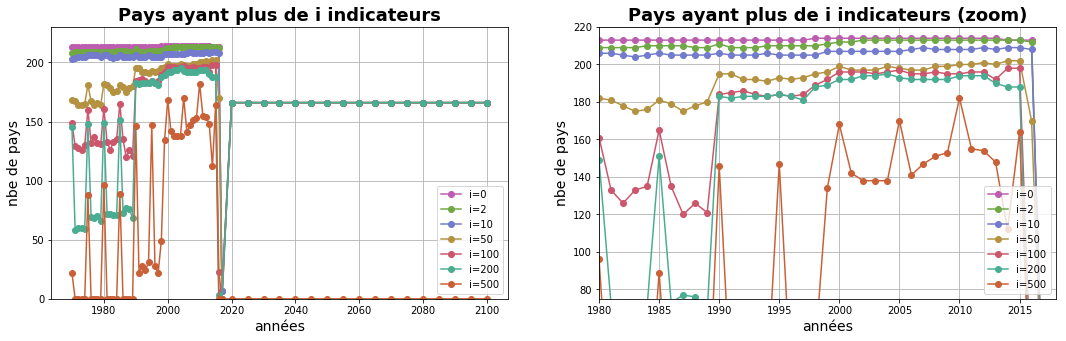

In [71]:
# Nbe de pays ayant un nbe d'indicateurs supérieur à n en fonction des années

nb_ind_cnt = data_c.groupby(['Country Name']).count()[li_annees]

def calc_nb_pay_rens (tab_n, years): # prend un tableau de seuils entiers et un tableau d'années
    tab = [ [nb_ind_cnt[nb_ind_cnt[str(i)]>j].index.size for i in years] for j in tab_n ]
    res = np.array(tab).T
    return res

fig = plt.figure(figsize = (18,5))

countrys = [nb_ind_cnt.index[i][0] + " - " + nb_ind_cnt.index[i][1] for i in range(nb_ind_cnt.index.size)]
tab_n = [0,2,10,50,100, 200, 500]
x =  [int(y) for y in li_annees]
y = calc_nb_pay_rens(tab_n,x)
colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]
labels = ["i="+str(i) for i in tab_n]

plot1 = plt.subplot(1,2,1)
[plot1.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot1.set_ylim(0,230)
plot1.set_xlabel("années", fontsize = 14), plot1.set_ylabel("nbe de pays", fontsize = 14)
plot1.set_title("Pays ayant plus de i indicateurs", fontsize = 18, fontweight = 'bold')
plot1.legend(loc = 'lower right'), plt.grid()

plot2 = plt.subplot(1,2,2)
[plot2.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot2.set_xlim(1980,2018), plot2.set_ylim(75,220)
plot2.set_xlabel("années", fontsize = 14), plot2.set_ylabel("nbe de pays", fontsize = 14)
plot2.set_title("Pays ayant plus de i indicateurs (zoom)", fontsize = 18, fontweight = 'bold')
plot2.legend(loc = 'lower right'), plt.grid()
plt.show() 

- Plus de la moitié des pays ont plus de 500 indicateurs remplis pour chaque année à partir de 2000.
- Plus de 80% des pays ont plus de 200 indicateurs remplis chaque année à partir de 2000.
- Tous les pays ont au moins 1 indicateur
- 167 pays ont des projections d'indicateurs (entre 200 et 500)
- les données sont très rares pour l'année 2017 (7 indicateurs au plus)

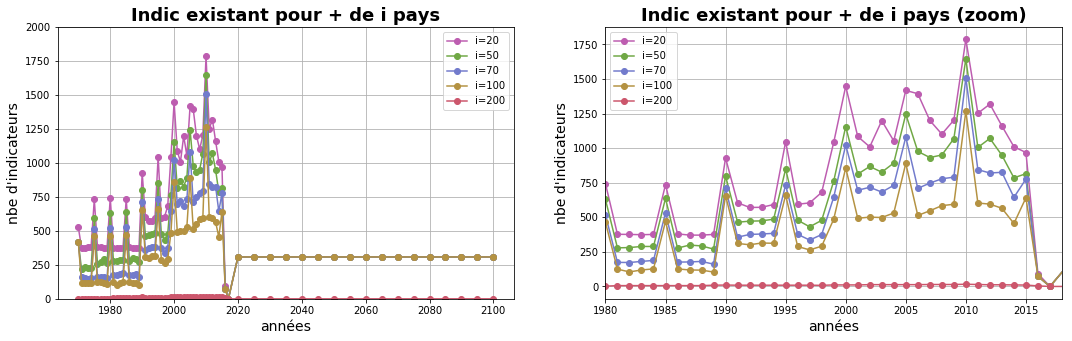

In [72]:
# Nbe d'indicateurs existant pour plus de n pays selon les années

nb_pay_cnt = data_c.groupby(['Indicator Name']).count()[li_annees]

def calc_nb_ind_rens (tab_n, years): # prend un tableau de seuils entiers et un tableau d'années
    tab = [ [nb_pay_cnt[nb_pay_cnt[str(i)]>j].index.size for i in years] for j in tab_n ]
    res = np.array(tab).T
    return res

fig = plt.figure(figsize = (18,5))

countrys = [nb_ind_cnt.index[i][0] + " - " + nb_ind_cnt.index[i][1] for i in range(nb_ind_cnt.index.size)]
tab_n = [20,50,70,100, 200]
x =  [int(y) for y in li_annees] # liste des anneés
y = calc_nb_ind_rens(tab_n,x)
colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]
labels = ["i="+str(i) for i in tab_n]

plot1 = plt.subplot(1,2,1)
[plot1.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot1.set_ylim(0,2000)
plot1.set_xlabel("années", fontsize = 14), plot1.set_ylabel("nbe d'indicateurs", fontsize = 14)
plot1.set_title("Indic existant pour + de i pays", fontsize = 18, fontweight = 'bold')
plot1.legend(loc = 'upper right'), plt.grid()

plot2 = plt.subplot(1,2,2)
[plot2.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot2.set_xlim(1980,2018), #plot2.set_ylim(75,220)
plot2.set_xlabel("années", fontsize = 14), plot2.set_ylabel("nbe d'indicateurs", fontsize = 14)
plot2.set_title("Indic existant pour + de i pays (zoom)", fontsize = 18, fontweight = 'bold')
plot2.legend(loc = 'upper left'), plt.grid()
plt.show() 

- Environ 500 indicateurs sont renseignés chaque année pour plus de 100 pays (la moitié des pays) de 2000 à 2015.
- Seuls 20 pays environ ont plus de 1000 indicateurs renseignés chaque année.
- 167 pays sur les 214 (voir graphes précédents) ont des projections pour 308 indicateurs sur les 3665.

#### Suppression de lignes et de colonnes

L'exploration ci-dessus nous permet de prendre des décisions par rapport aux années et aux pays sous-remplis :
* On garde les années de 1990 à 2015 inclus, puis on élimine les lignes entièrement nulles (sans indicateur renseigné).
* On garde seulement les pays qui ont plus de 2 % des cases indicateur/année remplies

In [73]:
# Suppression des colonnes années inutiles, et des lignes entièrement vides après opération
li_col_supp = [annee for annee in list(li_annees) if int(annee)<1990 or int(annee)>2015] # colonnes à supprimer
print("Taille de la dataframe 'data_c' avant suppression des colonnes : ", data_c.shape)
data_c.drop(columns = li_col_supp, inplace = True)
print("Taille de la dataframe 'data_c' après suppression des colonnes : ", data_c.shape)
li_annees_sel = sorted(Diff(li_annees, li_col_supp)[0]) # colonnes à conserver
lign_supp = sorted(Diff(data_c[li_annees_sel].dropna\
                    (how='all', axis = 0, inplace=False).index, data_c.index)[1]) # index des lignes vides à supprimer
data_c.drop(index = lign_supp, inplace = True) 
print("Taille de la dataframe 'data_c' après suppression des lignes vides : ", data_c.shape)

Taille de la dataframe 'data_c' avant suppression des colonnes :  (784310, 71)
Taille de la dataframe 'data_c' après suppression des colonnes :  (784310, 32)
Taille de la dataframe 'data_c' après suppression des lignes vides :  (344238, 32)


In [74]:
# Suppression des pays ayant moins de 2% de cases indicateur/année renseignées
# (soit environ 2300 pour 32 années et 3665 indicateurs)
gp = data_c.groupby(['Country Name']).count() # nbe de cases renseignées pour chaque pays et chaque année
gp_sum = gp[gp.columns[5:]].sum(axis=1) # nbe de cases renseignées pour chaque pays (ttes années cumulées)
pays_supp = list(gp_sum[gp_sum<2300].index) # liste des pays à supprimer (16)
tab_index_supp = [list(data_c[data_c["Country Name"]==pays].index) for pays in pays_supp] # tab d'index des lignes à suprimer
li_lign_supp = sorted([j for index in tab_index_supp for j in index]) # liste des lignes à supprimer
print("Suppression de {} pays, (soit {} lignes) à savoir :\n{}".format(len(pays_supp), len(li_lign_supp), pays_supp))
print("Taille de la dataframe 'data_c' avant suppression : ", data_c.shape)
data_c.drop(index = li_lign_supp, inplace = True)
print("Taille de la dataframe 'data_c' après suppression : ", data_c.shape)

Suppression de 16 pays, (soit 2805 lignes) à savoir :
['American Samoa', 'Channel Islands', 'Curacao', 'Faroe Islands', 'French Polynesia', 'Greenland', 'Guam', 'Isle of Man', 'Kosovo', 'New Caledonia', 'Northern Mariana Islands', 'Sint Maarten (Dutch part)', 'South Sudan', 'St. Martin (French part)', 'Tuvalu', 'Virgin Islands (U.S.)']
Taille de la dataframe 'data_c' avant suppression :  (344238, 32)
Taille de la dataframe 'data_c' après suppression :  (341433, 32)


#### Exploration en vue de la suppression de lignes (indicateurspays) sous-remplis

On s'intéresse maintenant aux indicateurs peu renseignés. Y a-t-il des indicateurs trop peu renseignés dans la plage de temps qui nous intéresse (1990-2015) ? Le manque d'information concerne-t-il en particulier les années ou les pays ? 

In [75]:
# Exploration des indicateurs disponibles pour un nombre insuffisant de pays ou d'années
gp = data_c.groupby(['Indicator Code']).count() # nbe de cases renseignées pour chaque indicateur et chaque année
gp_sum = gp[gp.columns[5:]].sum(axis=1) # nbe de cases renseignées pour chaque indicateur (ttes années cumulées)

#np.sum(gp_sum) # 3043320 cases en tout
#len(data_c['Indicator Code'].unique()) # 3647 indicateurs différents

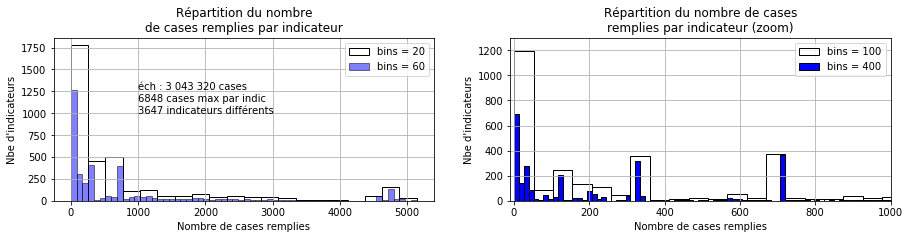

In [76]:
#----------------------------------
fig1 = plt.figure(figsize = (15,3))
plot1 = plt.subplot(1,2,1)
# échantillon de 3043320 cases remplies, 6848 cases maximum par indicateur
plot1.hist(gp_sum, bins = 20, fc = 'None', ec = 'k', label='bins = 20')
plot1.hist(gp_sum, bins = 60, fc = 'b', alpha = 0.5, ec = 'k', label='bins = 60')
plt.xlabel("Nombre de cases remplies"), plt.ylabel("Nbe d'indicateurs")
plt.title('Répartition du nombre\nde cases remplies par indicateur')
plt.grid(True), plt.legend()
plt.text(1000, 1000,"éch : 3 043 320 cases\n6848 cases max par indic\n3647 indicateurs différents")
#plt.xlim(40, 160), plt.ylim(0, 0.03)
#---
plot2 = plt.subplot(1,2,2)
plot2.hist(gp_sum, bins = 100, fc = 'None', ec = 'k', label='bins = 100')
plot2.hist(gp_sum, bins = 400, fc = 'b', ec = 'k',  label='bins = 400')
plt.xlabel("Nombre de cases remplies"), plt.ylabel("Nbe d'indicateurs")
plt.xlim(-10, 1000), plt.ylim(0, 1300), plt.grid(True) , plt.legend()
plt.title('Répartition du nombre de cases\nremplies par indicateur (zoom)')
plt.show()
#----------------------------------

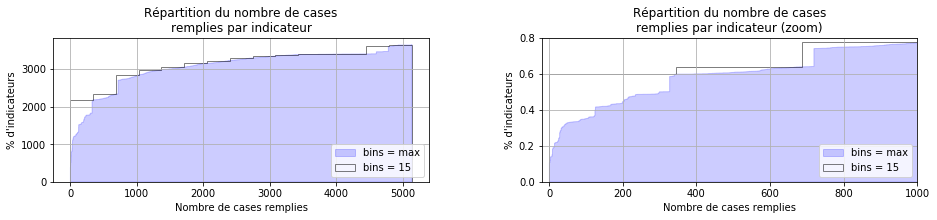

In [77]:
#----------------------------------
fig2 = plt.figure(figsize = (20,2))
plot3 = plt.subplot(1,2,1) 
plot3.hist(gp_sum, bins = 3700, fc = 'b', alpha = 0.2, ec = 'b', density=False,\
           histtype='stepfilled', cumulative=True, label='bins = max')
plot3.hist(gp_sum, bins = 15, fc = 'r', alpha = 0.5, ec = 'k', density=False,\
           histtype='step', cumulative=True, label='bins = 15')
plt.xlabel("Nombre de cases remplies"), plt.ylabel("% d'indicateurs")
plt.grid(True), plt.legend(loc='lower right')#, plt.xlim(-20, 1000), plt.ylim(0, 1000)
plt.title('Répartition du nombre de cases\nremplies par indicateur')
#---
plot4 = plt.subplot(1,2,2)
plot4.hist(gp_sum, bins = 3700, fc = 'b', alpha = 0.2, ec = 'b', density=True,\
           histtype='stepfilled', cumulative=True, label='bins = max')
plot4.hist(gp_sum, bins = 15, fc = 'r', alpha = 0.5, ec = 'k', density=True,\
           histtype='step', cumulative=True, label='bins = 15')
plt.xlabel("Nombre de cases remplies"), plt.ylabel("% d'indicateurs")
plt.grid(True), plt.legend(loc='lower right'), plt.xlim(-20, 1000), plt.ylim(0, 0.8)
plt.title('Répartition du nombre de cases\nremplies par indicateur (zoom)')

plt.gcf().subplots_adjust(left = 0.1, bottom = 0.2, right = 0.7, top = 1.2, wspace = 0.3, hspace = 0.5)
plt.show()
#----------------------------------

Il y a plus de 2300 indicateurs sur 3647 (63%) qui ont moins de 700 cases remplies. Intéressons-nous au taux de remplissage de ces indicateurs en particulier.

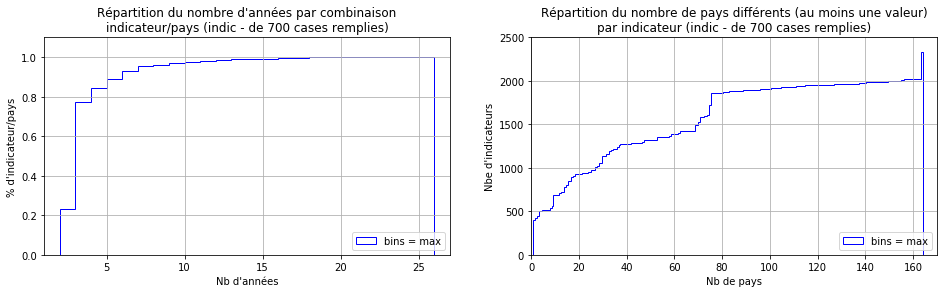

In [78]:
li_ind_m700 = gp_sum[gp_sum.values<700].index # liste des codes des 2332 indicateurs concernés
df_ind_m700 = data_c[data_c["Indicator Code"].isin(li_ind_m700)] # 126805 lignes concernées
ind_uni = df_ind_m700["Indicator Code"].unique() # liste des noms des indicateurs concernés
# nombre d'années calc par indic et par pays
nb_ann = df_ind_m700[df_ind_m700.columns[5:]].count(axis=1)  # (25 bins de 2 à 26)
# nombre de pays différents par indicateur (pour au moins une année)
tab = df_ind_m700.groupby(["Indicator Code", "Country Code"])[li_annees_sel].count().sum(axis=1) # nbe val par ind/pay
nb_pay = [len(tab.loc[code]) for code in ind_uni] # liste des nbes de pays ayant au -1 valeur par indic (pas de ligne nulle)
#nb_pay =  [len(tab.loc[code][(tab.loc[code]!=0).values]) for code in ind_uni]  # en tenant compte d'éventuelles lignes nulles

#----------------
fig = plt.figure(figsize = (16,4))
#----------------
plot1 = plt.subplot(1,2,1)
plot1.hist(nb_ann, bins = 24, fc = 'b', alpha = 1, ec = 'b', density=True,\
           histtype='step', cumulative=True, label='bins = max')
# plot1.hist(nb_ann, bins = 15, fc = 'r', alpha = 0.5, ec = 'k', density=True,\
#            histtype='step', cumulative=True, label='bins = 15')
plt.title("Répartition du nombre d'années par combinaison\nindicateur/pays (indic - de 700 cases remplies)")
plt.xlabel("Nb d'années"), plt.ylabel("% d'indicateur/pays")
plt.xlim(1, 27), plt.ylim(0, 1.1), plt.grid(), plt.legend(loc='lower right')

#----------------
plot2 = plt.subplot(1,2,2)
plot2.hist(nb_pay, bins = 215, fc = 'b', alpha = 1, ec = 'b', density=False,\
           histtype='step', cumulative=True, label='bins = max')
# plot1.hist(nb_ann, bins = 15, fc = 'r', alpha = 0.5, ec = 'k', density=True,\
#            histtype='step', cumulative=True, label='bins = 15')
plt.title('Répartition du nombre de pays différents (au moins une valeur)\npar indicateur (indic - de 700 cases remplies)')
plt.xlabel("Nb de pays"), plt.ylabel("Nbe d'indicateurs")
plt.xlim(0, 170), plt.ylim(0, 2500), plt.grid(), plt.legend(loc='lower right')

plt.show()

Précisions au sujet des indicateurs peu remplis (moins de 700 cases sur 26*214 = 5564 cases)
 - combien d'années sont calculées par indicateur ?
-> La grande majorité des combinaisons pays/indicateur sont calculés pour moins de 4 années. 20% des indicateurs nationaux sont calculés pour seulement 2 années entre 1990 et 2015. On choisit de les éliminer.
 - combien de pays différents par indicateur ?
-> Il n'y a pas de ligne de démarcation nette qui nous permettrait de choisir les indicateurs.
Sur les 2300 indicateurs restant, la moitié ne sont disponibles que pour moins de 30 pays. On choisit de ne pas éliminer d'indicateurs sur ce critère.

#### Suppression des lignes indicateur/pays calculés pour seulement 1 ou 2 années dans la plage [1990,2015]

In [343]:
######### ATTENTION, éliminé toutes les combi ayant moins de 5 années calculées
li_supp = data_c[data_c[data_c.columns[6:]].count(axis=1)<5].index # 37634, 76279 = 113913 lignes à supprimer
print("Taille de la dataframe 'data_c' avant suppression des lignes indicateurs : ", data_c.shape)
data_c.drop(index = li_supp, inplace = True)
print("Taille de la dataframe 'data_c' après suppression des lignes : ", data_c.shape)

Taille de la dataframe 'data_c' avant suppression des lignes indicateurs :  (212695, 32)
Taille de la dataframe 'data_c' après suppression des lignes :  (201893, 32)


In [344]:
### Nouvelle heatmap du nombre d'indicateurs non nuls (pays/années)

nb_ind_cnt = data_c.groupby(['Country Name']).count()[li_annees_sel]
nb_ind_cnt.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,648,277,236,310,285,646,236,236,247,266,612,294,290,397,367,724,320,381,375,426,756,436,410,412,377,308
Albania,698,351,328,331,352,725,451,340,347,454,1052,610,361,616,537,784,518,574,646,660,1025,756,713,733,598,367
Algeria,875,518,520,497,520,910,555,532,348,623,980,632,611,641,655,1015,665,707,615,682,1022,677,503,513,422,322
Andorra,43,42,42,42,42,42,43,44,225,200,200,199,411,389,437,435,550,343,368,338,345,325,366,376,329,108
Angola,313,316,299,249,248,248,249,250,403,356,330,325,356,277,265,271,293,309,429,429,430,454,253,273,203,263


In [345]:
data_c.to_csv('../DONNEES/data_c.csv', index = False)

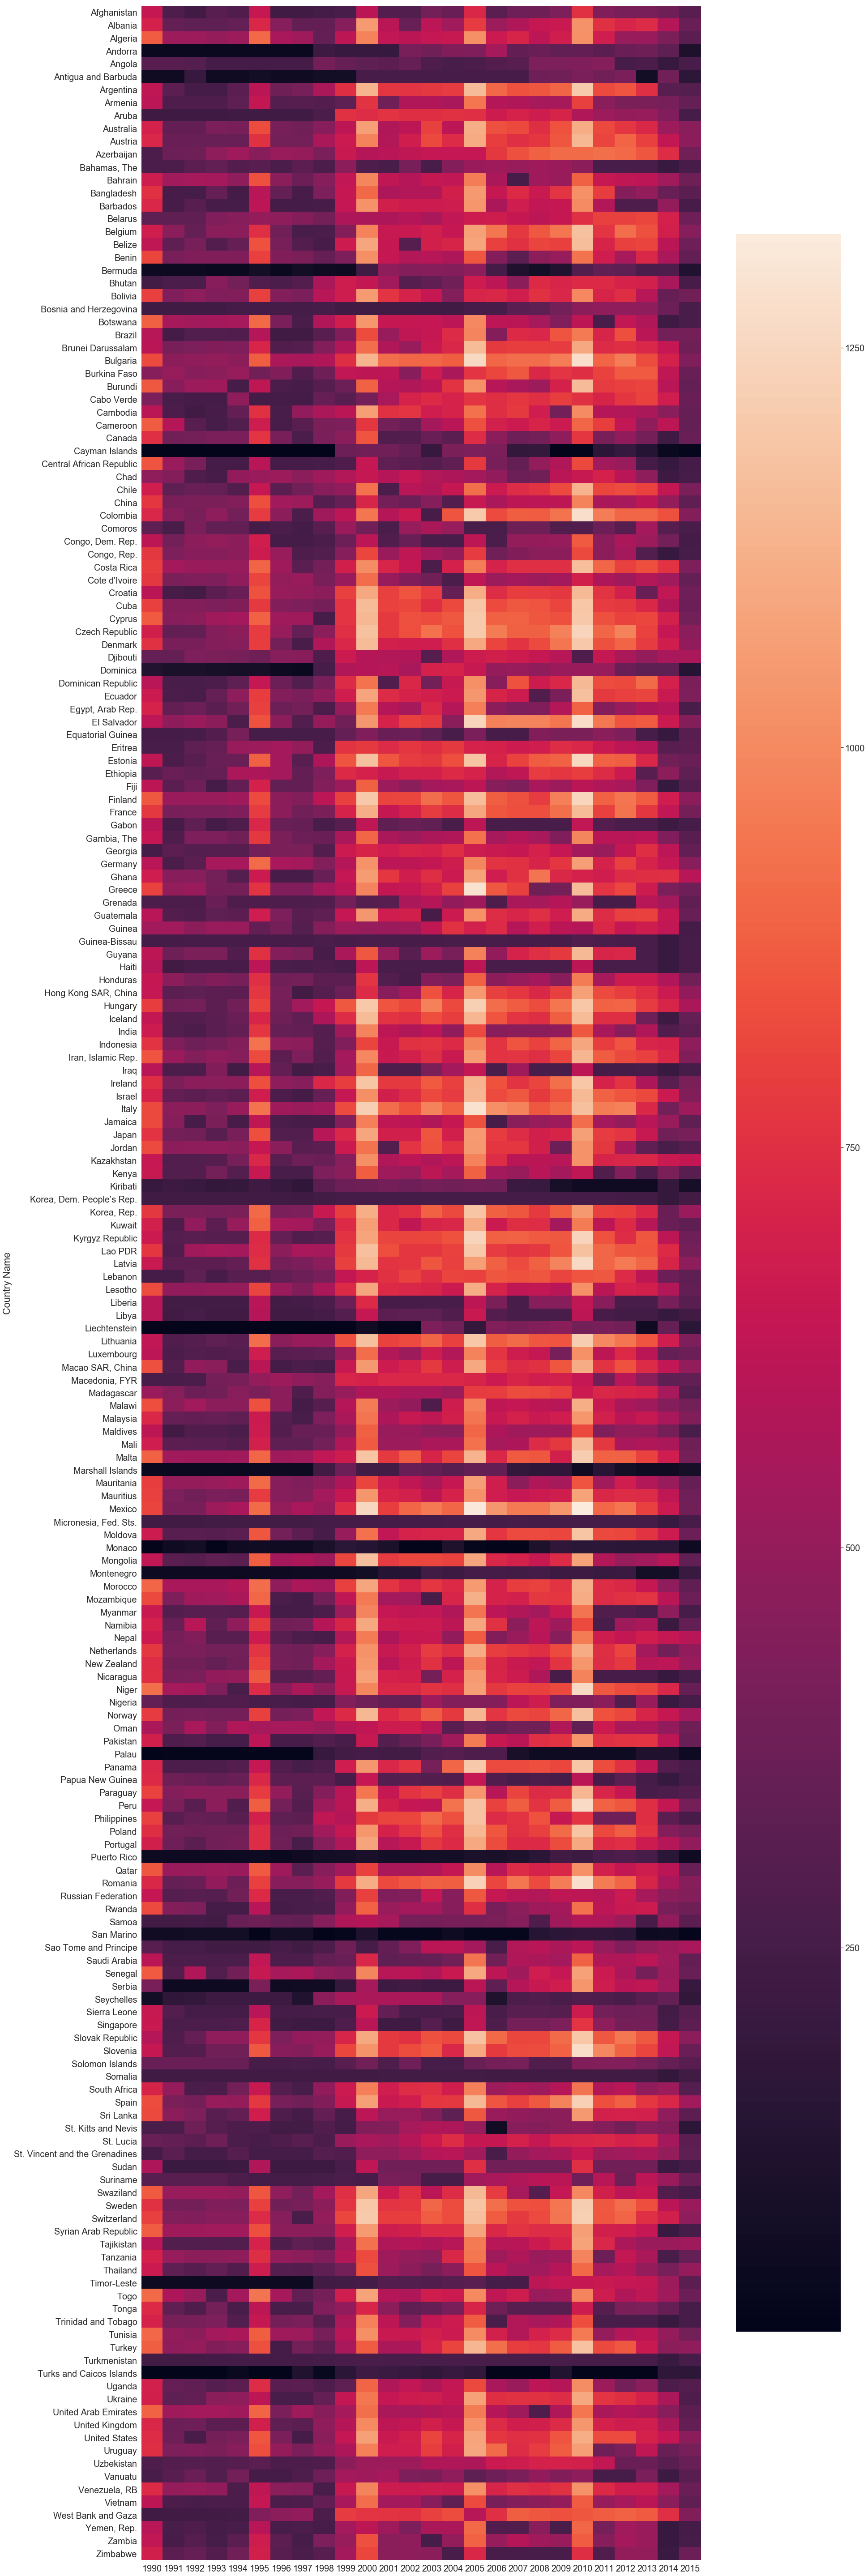

In [346]:
# Tableau des nombres d'indicateurs dispo pour chaque pays et chaque année
sns.set(font_scale=1.8)
fig = plt.figure(figsize = (28,105))
heat_map = sns.heatmap(nb_ind_cnt)

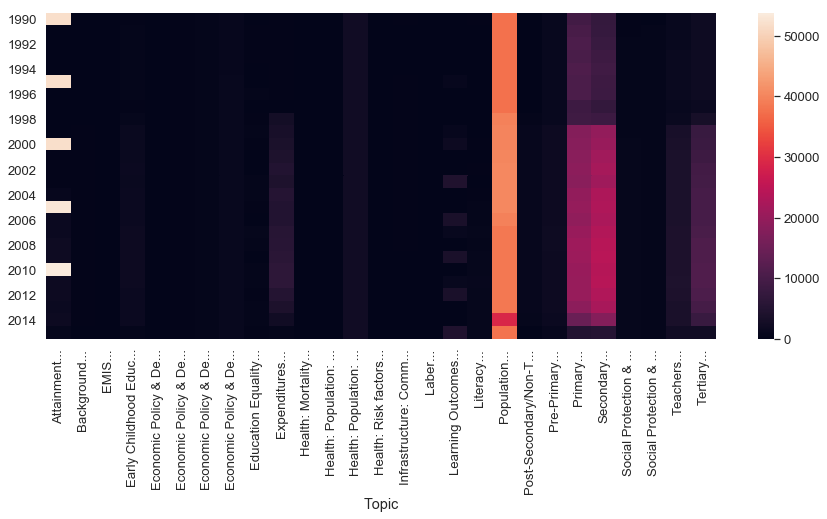

In [347]:
# Tableau des nombres de valeurs d'indicateurs dispo chaque par topic
sns.set(font_scale=1.2)
gb = data_c[['Topic'] + li_annees_sel].groupby('Topic').count()#.sum(axis = 1) 
fig = plt.figure(figsize = (15,6))
heat_map = sns.heatmap(gb.T)
# format text labels
xticklabels = [] # fmt = '{:0.2f}'
for item in heat_map.get_xticklabels():
    item.set_text(item.get_text()[:20]+"...") #(fmt.format(float(item.get_text())))
    xticklabels += [item]
heat_map.set_xticklabels(xticklabels)
plt.show()
#gb.head()

#### Multiindexage de la dataframe data_c et permutation des axes

Afin de faciliter la recherche des outliers, les calculs de corrélation entre les différents indicateurs, l'ANOVA et les tracés des indicateurs pertinents, on effectue les opérations suivantes :
- multiindexage de lignes par 'Topic', 'Indicator Code'
- indexation des années en lignes plutôt qu'en colonnes grâce à un nouvel index 'Year'
- multiindexage de 'Region' et 'Country Code' en colonnes

In [348]:
# 'Topic', 'Indicator Code','Indicator Name', 'Region', 'Country Name', 'Country Code'
data_c_mod = data_c[['Topic','Indicator Code','Region','Country Name']+li_annees_sel].copy(deep = True)
data_c_mod.set_index(['Topic','Indicator Code','Region','Country Name'], inplace = True)
data_c_mod.columns = pd.MultiIndex.from_product([data_c_mod.columns, ['val']], names = ['Year', 'nom'])
data_c_mod.columns = data_c_mod.columns.swaplevel(0, 1)
data_c_mod = data_c_mod.unstack(['Region','Country Name'])
data_c_mod.columns = data_c_mod.columns.droplevel()
data_c_mod.sort_index(inplace=True)
data_c_mod = data_c_mod.dropna(how = 'all', inplace = False, axis = 0)
data_c_mod = data_c_mod.T.dropna(how = 'all', inplace = False, axis = 0)
data_c_mod.sort_index(inplace=True)
data_c_mod.shape # 5148,2310 -> 11 891 880 cases
data_c_mod.head()

Topic                                               Attainment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               \
Indicator Code                             BAR.NOED.1519.FE.ZS BAR.NOED.1519.ZS BAR.NOED.15UP.FE.ZS BAR.NOED.15UP.ZS BAR.NOED.2024.FE.ZS BAR.NOED.2024.ZS BAR.NOED.2529.FE.ZS BAR.NOED.2529.ZS BAR.NOED.25UP.FE.ZS BAR.NOED.25UP.ZS BAR.NOED.3034.FE.ZS BAR.NOED.3034.ZS BAR.NOED.3539.FE.ZS BAR.NOED.3539.ZS BAR.NOED.4044.FE.ZS BAR.NOED.4044.ZS BAR.NOED.4549.FE.ZS BAR.NOED.4549.ZS BAR.NOED.5054.FE.ZS BAR.NOED.5054.ZS BAR.NOED.5559.FE.ZS BAR.NOED.5559.ZS BAR.NOED.6064.FE.ZS BAR.NOED.6064.ZS BAR.NOED.6569.FE.ZS BAR.NOED.6569.ZS BAR.NOED.7074.FE.ZS BAR.NOED.7074.ZS BAR.NOED.75UP.FE.ZS BAR.NOED.75UP.ZS BAR.POP.1519 BAR.POP.1519.FE BAR.POP.15UP BAR.POP.15UP.FE BAR.POP.2024 BAR.POP.2024.FE BAR.POP.2529 BAR.POP.2529.FE BAR.POP.25UP BAR.POP.25UP.FE BAR.POP.3034 BAR.POP.3034.FE BAR.POP.3539 BAR.POP.3539.FE BAR.POP.4044 BAR.POP.4044.FE BAR.POP.4549 BAR.POP.4549.FE BAR.POP.5054 BAR.POP.5054.FE BAR.POP.5559 BAR.POP.5559.FE BAR.POP.6064 BAR.POP.6064.FE BAR.POP.6569 BAR.POP.6569.FE BAR.POP.7074   
Year Region              Country Name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1990 East Asia & Pacific Australia                         0.1              0.1                 1.3              1.1                 0.5              0.5                 0.5              0.5                 1.5              1.3                 0.7              0.7                 0.8              0.7                 0.9              0.8                 1.2              1.1                 2.0              1.7                 2.8              2.4                 2.6              2.2                 2.5              2.2                 2.5              2.2                 2.6              2.4       1388.0           677.0      13178.0          6645.0       1345.0           660.0       1401.0           692.0      10445.0          5308.0       1384.0           686.0       1296.0           648.0       1255.0           615.0        973.0           473.0        813.0           397.0        715.0           352.0        726.0           364.0        658.0           347.0        480.0   
                         Brunei Daru

In [349]:
data_c_mod.columns[1832]

('Teachers', 'OECD.TSAL.0.E10')

In [350]:
#data_c_mod[('Secondary', 'UIS.DR.2.GPV.G4.F')]
mi_col = data_c_mod.columns
mi_col.get_level_values(0) # Tous les topics des indicateurs
mi_col.get_level_values(1) # Tous les indicateurs

Index(['BAR.NOED.1519.FE.ZS', 'BAR.NOED.1519.ZS', 'BAR.NOED.15UP.FE.ZS', 'BAR.NOED.15UP.ZS', 'BAR.NOED.2024.FE.ZS', 'BAR.NOED.2024.ZS', 'BAR.NOED.2529.FE.ZS', 'BAR.NOED.2529.ZS', 'BAR.NOED.25UP.FE.ZS', 'BAR.NOED.25UP.ZS',
       ...
       'UIS.TEP.7.F', 'UIS.TEP.7.M', 'UIS.TEP.8', 'UIS.TEP.8.F', 'UIS.TEP.8.M', 'UIS.TE_100000.56', 'UIS.TE_100000.56.F', 'UIS.TE_100000.56.M', 'UIS.THAGE.4.A.GPV', 'UIS.THDUR.4.A.GPV'], dtype='object', name='Indicator Code', length=2085)

In [351]:
data_c_mod.to_csv('../DONNEES/data_c_mod.csv')

In [88]:
# Pas terrible l'enregistrement d'un fichier csv avec des multiindex...
# test = pd.read_csv('../DONNEES/data_c_mod.csv')
# test.head

In [352]:
print("Nombre de valeurs d'indicateurs non vides avant modification :\n{}, pour une taille de tableau de {} = {} cases"\
      .format(np.sum(~np.isnan(data_c[li_annees_sel].values)),data_c.shape,data_c.shape[0]*data_c.shape[1])) # 2 853 128
print("Nombre de valeurs d'indicateurs non vides après modification :\n{}, pour une taille de tableau de {} = {} cases"\
      .format(np.sum(~np.isnan(data_c_mod.values)),data_c_mod.shape,data_c_mod.shape[0]*data_c_mod.shape[1]))  # 2 853 128 sur 11 891 880 cases

Nombre de valeurs d'indicateurs non vides avant modification :
2765445, pour une taille de tableau de (201893, 32) = 6460576 cases
Nombre de valeurs d'indicateurs non vides après modification :
2765445, pour une taille de tableau de (5148, 2085) = 10733580 cases


### Corrélation entre indicateurs d'un même topic

In [358]:
data_c_mod.head()

Topic                                               Attainment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               \
Indicator Code                             BAR.NOED.1519.FE.ZS BAR.NOED.1519.ZS BAR.NOED.15UP.FE.ZS BAR.NOED.15UP.ZS BAR.NOED.2024.FE.ZS BAR.NOED.2024.ZS BAR.NOED.2529.FE.ZS BAR.NOED.2529.ZS BAR.NOED.25UP.FE.ZS BAR.NOED.25UP.ZS BAR.NOED.3034.FE.ZS BAR.NOED.3034.ZS BAR.NOED.3539.FE.ZS BAR.NOED.3539.ZS BAR.NOED.4044.FE.ZS BAR.NOED.4044.ZS BAR.NOED.4549.FE.ZS BAR.NOED.4549.ZS BAR.NOED.5054.FE.ZS BAR.NOED.5054.ZS BAR.NOED.5559.FE.ZS BAR.NOED.5559.ZS BAR.NOED.6064.FE.ZS BAR.NOED.6064.ZS BAR.NOED.6569.FE.ZS BAR.NOED.6569.ZS BAR.NOED.7074.FE.ZS BAR.NOED.7074.ZS BAR.NOED.75UP.FE.ZS BAR.NOED.75UP.ZS BAR.POP.1519 BAR.POP.1519.FE BAR.POP.15UP BAR.POP.15UP.FE BAR.POP.2024 BAR.POP.2024.FE BAR.POP.2529 BAR.POP.2529.FE BAR.POP.25UP BAR.POP.25UP.FE BAR.POP.3034 BAR.POP.3034.FE BAR.POP.3539 BAR.POP.3539.FE BAR.POP.4044 BAR.POP.4044.FE BAR.POP.4549 BAR.POP.4549.FE BAR.POP.5054 BAR.POP.5054.FE BAR.POP.5559 BAR.POP.5559.FE BAR.POP.6064 BAR.POP.6064.FE BAR.POP.6569 BAR.POP.6569.FE BAR.POP.7074   
Year Region              Country Name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1990 East Asia & Pacific Australia                         0.1              0.1                 1.3              1.1                 0.5              0.5                 0.5              0.5                 1.5              1.3                 0.7              0.7                 0.8              0.7                 0.9              0.8                 1.2              1.1                 2.0              1.7                 2.8              2.4                 2.6              2.2                 2.5              2.2                 2.5              2.2                 2.6              2.4       1388.0           677.0      13178.0          6645.0       1345.0           660.0       1401.0           692.0      10445.0          5308.0       1384.0           686.0       1296.0           648.0       1255.0           615.0        973.0           473.0        813.0           397.0        715.0           352.0        726.0           364.0        658.0           347.0        480.0   
                         Brunei Daru

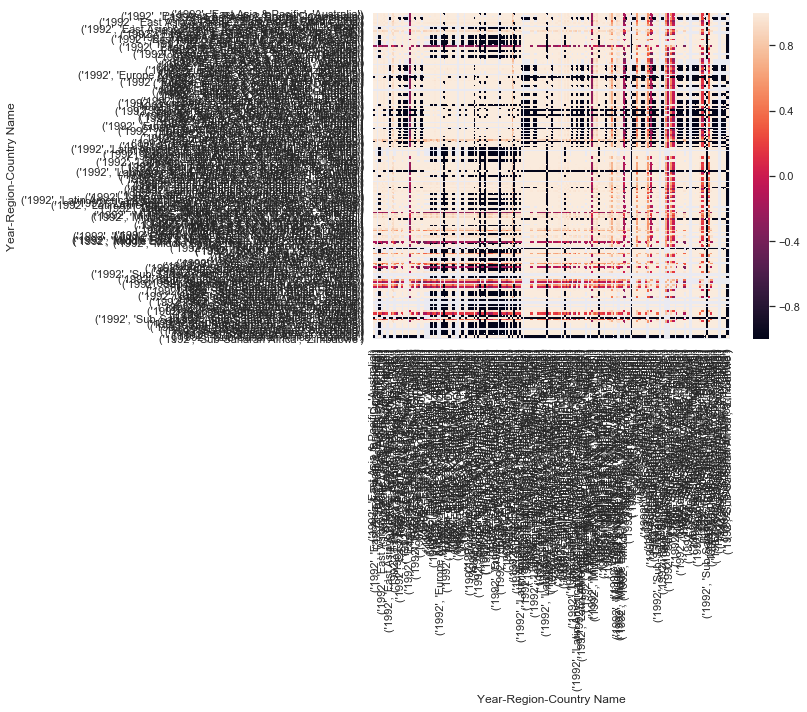

In [365]:
# Affichage d'un tableau de corrélation pour un extrait de la table data_c_mod
echant = data_c_mod.loc[idx[['1992','South Asia','Bangladesh'], idx['Pre-Primary',:]]].T 

my_corr = echant.corr()

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.matshow(my_corr)
# plt.xticks(range(len(my_corr.columns)),my_corr.columns, rotation = 85)
# plt.yticks(range(len(my_corr.columns)),my_corr.columns)
# plt.grid(False), plt.show()

fig = plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(my_corr, xticklabels=my_corr.columns.values, yticklabels=my_corr.columns.values)
plt.show()

### Détection des outliers

#### Evaluation du nombre d'outliers selon le seuil

Avant d'éliminer ou de remplacer les outliers, on voudrait en connaîre le nombre approximatif en fonction du nombre de sigma choisi pour le seuil. On trace les histogrammes du nombre d'outliers par indicateur pour un seuil de 3, 5, 10 et 20 sigmas :

In [366]:
# Prend un tableau de valeurs, calcule la moyenne, l'écart type
# et renvoie les valeurs au-delà ou en-deça de x fois l'écart-type

# def detOutliers_col(df,col,n):
#     moy = df[col].mean()
#     std = df[col].std()
#     out_val = [val for val in df[col].values if ((val<moy-(n*std)) or (val>moy+(n*std)))]
#     return df[df[col].isin(out_val)].index, out_val # renvoie les index de la ligne contenant les outliers, et leur valeur

def detOutliers_df(df_val,n): # prend en entrée une dataframe de toutes les valeurs d'un indicateur et le nbe de sigmas seuil
    moy = np.nanmean(df_val)
    std = np.nanstd(df_val)
    v_min = moy-(n*std)
    v_max = moy+(n*std)
    df_flat = df_val.flatten()[~np.isnan(df_val.flatten())]
    out_val = [val for val in df_flat if (val<v_min or val>v_max)]
    # index et colonne remplissant la condition, valeur correspondante... à faire
    return out_val # renvoie les outliers

In [367]:
#Détermination du nombre de sigmas à prendre en compte pour la détection des outliers
li_ind_uni = data_c['Indicator Code'].unique()
tab_df = [data_c[data_c['Indicator Code']==ind][li_annees_sel] for ind in li_ind_uni]

# tableau du nombre d'outliers pour tous les indicateurs avec n sigma
nb_std = [3,5,10,20]
tab_nb_out = [[len(detOutliers_df(df.values,n)) for df in tab_df] for n in nb_std]

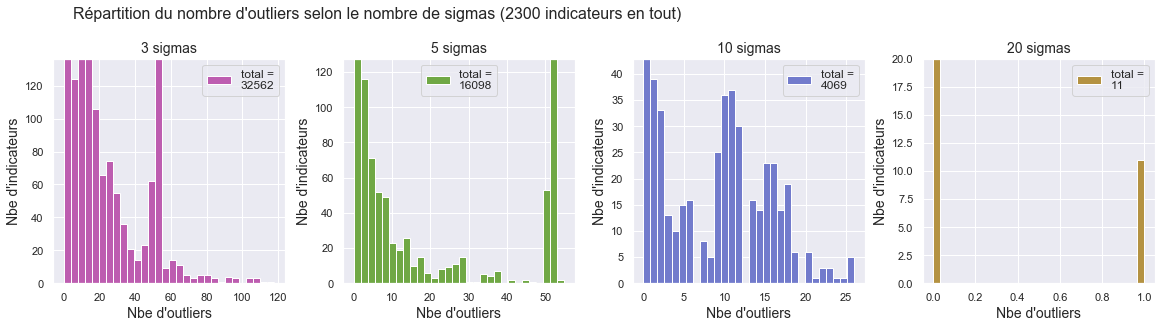

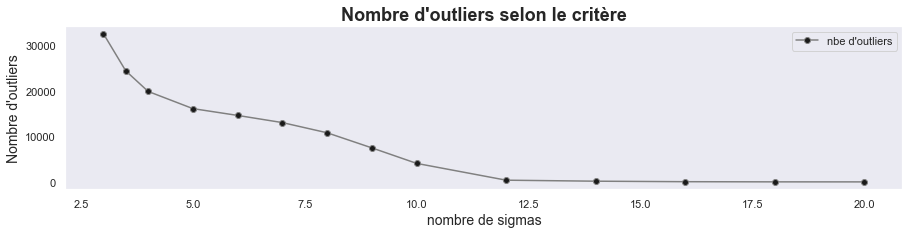

In [368]:
# Nombre d'outliers par indicateur pour un nombre n d'écart-type

fig = plt.figure(figsize = (18,8))

tab_plot = []
for i in range(len(tab_nb_out)):
    tab_plot.append(plt.subplot(1,4,i+1))
    tab_plot[i].hist(tab_nb_out[i], bins = 30, color = colors[i],\
                     label = "total =\n"+str(sum(tab_nb_out[i])))
    plt.xlabel("Nbe d'outliers", fontsize=14), plt.ylabel("Nbe d'indicateurs", fontsize=14)
    #plt.xlim(0, 120)
    y_lim = (np.histogram(tab_nb_out[i], bins = 30)[0][1]*1.1)
    my_y_lim = y_lim if y_lim != 0 else 20
    plt.ylim(0, my_y_lim)
    #plt.text(0,my_y_lim*0.05, "total = "+str(sum(tab_nb_out[i])), fontsize=14)
    plt.title(str(nb_std[i])+" sigmas", fontsize=14)
    plt.grid(True), plt.legend(fontsize=12)

plt.gcf().subplots_adjust(left = 0.25, bottom = 0.5, right = 1.1, top = 0.89, wspace = 0.25, hspace = 0.2)
fig.suptitle("Répartition du nombre d'outliers selon le nombre de sigmas (2300 indicateurs en tout)", fontsize=16)
plt.show()

#-----------------------------

fig = plt.figure(figsize = (15,3))
plot5 = plt.subplot(1,1,1)
# tableau du nombre d'outliers pour tous les indicateurs avec n sigma
nb_std = [3,3.5,4,5,6,7,8,9,10,12,14,16,18,20]
nb_out_std = [sum([len(detOutliers_df(df.values,n)) for df in tab_df]) for n in nb_std]
plot5.plot (nb_std, nb_out_std, '-o', label = "nbe d'outliers", color = 'grey', markerfacecolor = 'k')
#plot5.set_xlim(1980,2018), #plot5.set_ylim(75,220)
plot5.set_xlabel("nombre de sigmas", fontsize = 14), plot5.set_ylabel("Nombre d'outliers", fontsize = 14)
plot5.set_title("Nombre d'outliers selon le critère", fontsize = 18, fontweight = 'bold')
plot5.legend(loc = 'upper right'), plt.grid()
plt.show() 

#### Elimination des outliers

On souhaite éliminer les valeurs aberrantes (outliers) au-delà et en deça de 3 sigmas. On calcule le zscore de tous les indicateurs en se basant sur l'ensemble des valeurs qu'il peut prendre selon les années ([1995;2015]) et les pays (214 pays sélectionnés).

In [369]:
# calcule le zscore colonne par colonne, renvoie les z-scores ligne par ligne
data_c_mod_z = data_c_mod.copy(deep=True)

In [370]:
# Calcul pour chaque indicateur du z-score et remplissage d'une nouvelle dataframe
for (c1,c2) in data_c_mod.columns :
    data_c_mod_z[(c1,c2)] = (data_c_mod[(c1,c2)] - data_c_mod[(c1,c2)].mean()) / data_c_mod[(c1,c2)].std(ddof=0)

In [371]:
# crée une nouvelle dataframe sans outliers
data_c_mod_wo_out = data_c_mod.copy(deep=True)
#np.warnings.filterwarnings('ignore')
data_c_mod_wo_out = data_c_mod.where(np.abs(data_c_mod_z.values) < 3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [372]:
# nombre des valeurs qui ne sont pas null dans les dataframes
print("nb d'outliers retirés : {}"\
      .format(sum(sum(~np.isnan(data_c_mod_z.values)))-sum(sum(~np.isnan(data_c_mod_wo_out.values)))))
print("nb de nan crées par le calc du zscore : {}"\
      .format(sum(sum(~np.isnan(data_c_mod.values)))-sum(sum(~np.isnan(data_c_mod_z.values)))))
sum(sum(~np.isnan(data_c_mod.values)))

nb d'outliers retirés : 32562
nb de nan crées par le calc du zscore : 39


2765445

Problème : apparemment, il existe des colonnes pour lesquelles l'écart-type est nul, ce qui renvoie un z-score null. Il y a 36 données qui sont dans ces colonnes.

In [375]:
moy = np.nanmean(data_c_mod.values[:,2011])
std = np.nanstd(data_c_mod.values[:,2011])
data_c_mod.values[3487:3490,2109:2013],\
data_c_mod_z.values[3487:3490,2109:2013],\
moy, std

my_df = pd.DataFrame(data_c_mod.values[3486:4884,2104:2111])
my_df.to_csv('../DONNEES/test2.csv')

In [380]:
# y a-t-il des lignes pour lesquelles le calcul du z-score donne lieu à la création d'un null ? lesquels ?
# (5148, 2310) ou (5148, 2085)
for j in range(data_c_mod.shape[1]): # colonnes
    for i in range(data_c_mod.shape[0]): # lignes
        if (~np.isnan(data_c_mod.values[i][j])) ^ ~(np.isnan(data_c_mod_z.values[i][j])): # logical_xor -> ^
            print("col = "+str(j)+"ind = "+str(i)+"  :  ",data_c_mod.values[i][j], data_c_mod_z.values[i][j])
        else:
            pass

col = 1880ind = 3487  :   100.0 nan
col = 1880ind = 3685  :   100.0 nan
col = 1880ind = 3883  :   100.0 nan
col = 1880ind = 4279  :   100.0 nan
col = 1880ind = 4477  :   100.0 nan
col = 1880ind = 4675  :   100.0 nan
col = 1880ind = 4873  :   100.0 nan
col = 1881ind = 3487  :   100.0 nan
col = 1881ind = 3685  :   100.0 nan
col = 1881ind = 3883  :   100.0 nan
col = 1881ind = 4279  :   100.0 nan
col = 1881ind = 4477  :   100.0 nan
col = 1881ind = 4675  :   100.0 nan
col = 1881ind = 4873  :   100.0 nan
col = 1882ind = 3487  :   100.0 nan
col = 1882ind = 3685  :   100.0 nan
col = 1882ind = 3883  :   100.0 nan
col = 1882ind = 4279  :   100.0 nan
col = 1882ind = 4477  :   100.0 nan
col = 1882ind = 4675  :   100.0 nan
col = 1882ind = 4873  :   100.0 nan
col = 1883ind = 3487  :   100.0 nan
col = 1883ind = 3685  :   100.0 nan
col = 1883ind = 3883  :   100.0 nan
col = 1883ind = 4279  :   100.0 nan
col = 1883ind = 4477  :   100.0 nan
col = 1883ind = 4873  :   100.0 nan
col = 1884ind = 3487  :   10

### Evaluation du degré de distinctivité des indicateurs entre pays par ANOVA

In [381]:
#df.head()
#data_c_mod.loc[idx[['1990','1995','2000','2005'],'South Asia',:], idx['Pre-Primary',:]].T 
df.loc[idx['1995',:,'China'], idx[:]].head() # df.loc[idx[:,:,:], idx['Attainment',:]]

Year  Region               Country Name     
1990  East Asia & Pacific  Australia           nan
                           Brunei Darussalam   nan
                           Cambodia            nan
                           China               nan
                           Fiji                nan
Name: (Learning Outcomes, LO.EGRA.CLPM.CHC.2GRD), dtype: float64

In [386]:
####### MEMO ########
#df.index.get_level_values(2) # tous les noms de pays dans l'ordre (dupliqués !!!)
#df.index.get_level_values(2).unique() # tous les noms de pays, unique 
#df.loc[idx[:,:,'China']] # toutes les valeurs pour la Chine
Pays_moy = df.groupby(level="Country Name").mean() # toutes les moyennes des années pour un pays
Pays_moy['France'] # moyenne de l'indicateur pour la France

0.40800000000000003

In [401]:
def calc_Fischer (df): # sur une dataframe regroupant les données d'un seul indicateur

    MOY = df.mean() # moyenne de toutes les indicateurs (années et pays)
    Pays_moy = df.groupby(level="Country Name").mean() # moyenne des valeurs par pays (ttes les années)
    Pays_count = df.groupby(level="Country Name").count() # nbe des valeurs par pays (ttes les années)

    SCT = np.nansum(np.square(df.values - MOY))# Somme des carrés des écarts totale
    DDL_T = df.count()-1 # Degré de liberté SCT (somme des counts(années dispo) de chaque classe (pays) - 1)

    SCE = np.nansum(Pays_count*(np.square(Pays_moy - MOY))) # Somme des carrés des écarts expliquée = interclasse
    DDL_E = len(Pays_moy)-1 # Degré de liberté SCE (nombre de classes (pays) -1)

    SCR = 0 # Somme des carrés des écarts résiduelle = intraclasse
    for pays in df.index.get_level_values(2).unique(): # pour chaque pays de la liste d'un indicateur
        SCR += (np.nansum((np.square(df.loc[idx[:,:,pays]]-Pays_moy[pays]))))
    # Degré de liberté SCR (somme des counts(années dispo) de chaque classe (pays) - nb de classes (pays))
    DDL_R = df.count()-len(Pays_moy)

    # Coeff de Fischer
    return  (SCE/DDL_E)/(SCR/DDL_R)
# (SCT, SCE, SCR), (DDL_T, DDL_E, DDL_R), df.count(), len(Pays_moy)
# Vérification :
#print (SCT, SCE, SCR, SCE+SCR)
#print (DDL_T,DDL_E,DDL_R)

In [389]:
# Egal à 0 : Learning Outcomes 	LO.EGRA.CLPM.CHC.2GRD
df = data_c_mod_wo_out[('Attainment','BAR.NOED.1519.FE.ZS')]
calc_Fischer (df)

((224946.26327152975, 196524.4168515298, 28421.846420000005),
 (705, 197, 508),
 706,
 198)

In [ ]:
# combinaisons indicateurs/pays ayant moins de 3 années remplies
#data_c[data_c[data_c.columns[6:]].count(axis=1)<3].index
#data_c_mod_wo_out.groupby('Country Name').count()

In [402]:
tab_coeff_F = [calc_Fischer(data_c_mod_wo_out[c1,c2]) for c1,c2 in data_c_mod_wo_out.columns]
df_score_F = pd.DataFrame(tab_coeff_F, index = data_c_mod_wo_out.columns)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [406]:
len(df_score_F.values),df_score_F[df_score_F.values==0]#,\
df_score_F[np.greater(0,df_score_F.values)]#, 
df_score_F[np.isnan(df_score_F.values)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


0
Topic    Indicator Code          
Teachers UIS.AFR.TRNTP.1.PU.F nan
         UIS.AFR.TRNTP.1.PU.M nan
         UIS.AFR.TRNTP.1.PU.T nan
         UIS.AFR.TRNTP.2.PU.F nan
         UIS.AFR.TRNTP.2.PU.M nan
         UIS.AFR.TRNTP.2.PU.T nan

In [405]:
len(df_score_F.values),\ # 2310 valeurs
# 6 nan, 118 = 0, 1577 > 0, 609 < 0 (= 2310)
#np.sum(np.isnan(df_score_F.values)),\ 
#np.sum(df_score_F.values==0)
#np.sum(np.greater(0, df_score_F.values))
df_score_F[df_score_F.values==0],\
# Attainment 	UIS.EA.UK.AG25T99 , Learning Outcomes 	LO.EGRA.CLPM.CHC.2GRD 	-0.0
df_score_F[np.greater(0,df_score_F.values)],\
# Attainment 	UIS.EA.5.AG25T99 	 Learning Outcomes 	LO.PIRLS.REA.P50 	-5.4
df_score_F[np.isnan(df_score_F.values)]
# Teachers 	UIS.AFR.TRNTP.2.PU.F, UIS.AFR.TRNTP.2.PU.M, UIS.AFR.TRNTP.2.PU.T, \
# UIS.AFR.TRNTP.3.PU.F, UIS.AFR.TRNTP.3.PU.M, UIS.AFR.TRNTP.3.PU.T

SyntaxError: unexpected character after line continuation character (<ipython-input-405-1378a5976e01>, line 1)

In [415]:
my_data = data_c_mod_wo_out[('Attainment','BAR.NOED.1519.FE.ZS')]\
.loc[~np.isnan(data_c_mod_wo_out[('Attainment','BAR.NOED.1519.FE.ZS')].values)]

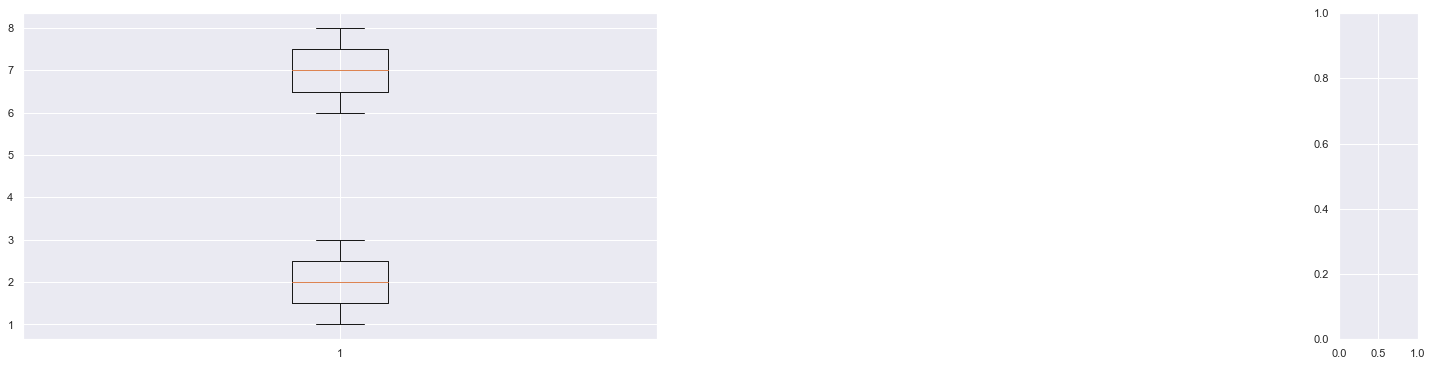

In [422]:
### violon plot (seaborn)
# montre la distribution également
# éliminer les quantiles extrêmes (zscore supérieur à 3...)
# chercher des indicateurs pertinents, valider, itérer.
fig, (plot1, plot2) = plt.subplots(1, 2, figsize = (25,6), gridspec_kw={'width_ratios': [30, 2]})
x=[1,2,3]
y=[8,7,6]
# plot1.plot(x, y)
# plot2.plot(y, x)

plot1 = plt.subplot(1,2,1)
#data.boxplot(column = li_annees)
plot1.boxplot(x)
plot1.boxplot(y)
#plot1.boxplot(my_data) 
#plot1.set_ylim(-300,550050)

#plot2 = plt.subplot(1,2,2)
# plot2.boxplot(data_val_0)
# #data[data.columns[52:]].dropna(inplace = False).boxplot(data.columns[52:])
# plot2.set_ylim(-3,20)

plt.show()

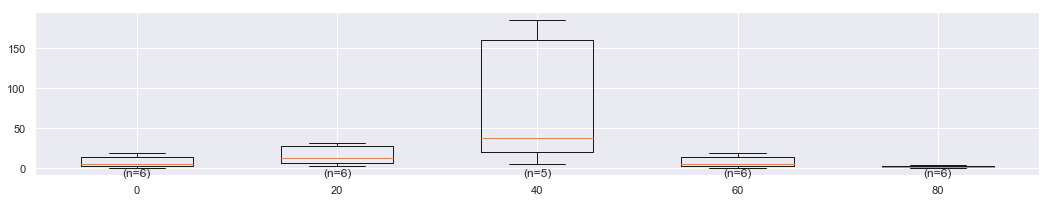

In [456]:
fig8 = plt.figure(figsize=(18,3))

taille_classe = 16
montants = [[0,5.3,16,3.8,2,18.6], [10,5.3,16,30.8,2,186], [5.3,160,38,20,186], [0,5.3,16,3.8,2,18.6], [0,0.3,1.6,3.8,2,1.86]]
groupes = []
# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, 10, 20)
tranches += 1 # on décale les tranches d'une demi taille de classe

for i in range(5):
    g = {'valeurs': montants[i],'centre_classe': i*20,\
        'taille': len(montants[i]), 'quartiles': [np.percentile(montants[i],p) for p in [25,50,75]]}
    groupes.append(g)
        
# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7, # largeur graphique des boxplots
            manage_xticks= False)
# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

### Exploration des mots clés dans les noms d'indicateurs

In [ ]:
list_pop = ["in", "of", "a", "and", "Per", "by", "the", "with", "to", "from",\
            "for", "who", "on", "are"] # liste des mots non considérés

# génération dictionnaire effectif mots-clés 
dic_occs = enum_mots_cmpt(data["Indicator Name"], 30) # à parti des noms d'indicateurs dans "Data"
dic_occs = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables
dic_occs2 = enum_mots_cmpt(data["Country Name"], 30) # à partir des indicateurs uniques
dic_occs2 = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables

nuageMots(dic_occs), nuageMots(dic_occs2)

In [ ]:
histMots(dic_occs), histMots(dic_occs2)

PBE A REGLER : les deux graphes sortent les mêmes résultats !!!!

## -------------
## BROUILLON

In [ ]:
# Slicing de la dataframe multiindex (voir plus haut : idx = pd.IndexSlice)
df_Attainment = data_c_mod.loc[idx[:,:,:], idx['Attainment',:]] # sélection de toutes les colonnes topic 'Attainment'
df_Attainment.head()